In [1]:
from src.utils.Visualisation import plot_ROC_simple
from src.utils.PathManager import PathManager
from src.utils.BayesianLabel import BayesianLabeler as Labeller 
from src.utils.FeatureExtractor import *
import pandas as pd 
import numpy as np 
from datetime import timedelta
import matplotlib.pyplot as plt 
from scipy.signal import savgol_filter    


In [ ]:
well_code = "POND1"

In [ ]:
model = FeatureExtractor(well_code)

In [ ]:
model.get_failure_label()

In [ ]:
def plot_data(all_data, incorrect_date, fail_type):
    processed_data = all_data.loc[incorrect_date]
    fig, ax = plt.subplots(2,3, figsize=(20,8))
    fig.suptitle(incorrect_date.strftime("%Y-%m-%d")+" " + fail_type)

    ax[0][0].plot(processed_data['filtered_data'])
    ax[0][0].grid()
    ax[0][0].set_title("Signal")

    ax[0][1].plot(processed_data['first'])
    ax[0][1].grid()
    ax[0][1].set_title("First Derivative")

    ax[0][2].plot(processed_data['second'])
    ax[0][2].grid()
    ax[0][2].set_title("Second Derivative")


    ax[1][0].plot(processed_data['filtered_data_onset'])
    ax[1][0].grid()
    ax[1][0].set_title("Signal to Onset")


    ax[1][1].plot(processed_data['first_onset'])
    ax[1][1].grid()
    ax[1][1].set_title("First Derivative Onset")


    ax[1][2].plot(processed_data['second_onset'])
    ax[1][2].grid()
    ax[1][2].set_title("Second Derivative Onset")
    
def plot_outage_data(raw_df, all_data, incorrect_date, fail_type):
    fig, ax = plt.subplots(3,1, figsize=(20,8))
    fig.suptitle(f"{incorrect_date} {fail_type}")
    VOLTAGE_raw = np.array(raw_df["ROC_VOLTAGE"].loc[incorrect_date])
    mask_VOLTAGE = np.array(raw_df["Mask_ROC_VOLTAGE"].loc[incorrect_date])
    VOLTAGE_index = np.arange(1440)[mask_VOLTAGE==1]
    VOLTAGE_processed = VOLTAGE_raw[mask_VOLTAGE==1]
    VOLTAGE_outage = None #all_data["VOLTAGE_interval"].loc[incorrect_date]
    
    FLOW_raw = np.array(raw_df["FLOW"].loc[incorrect_date])
    mask_FLOW = np.array(raw_df["Mask_FLOW"].loc[incorrect_date])
    FLOW_index = np.arange(1440)[mask_FLOW==1]
    FLOW_processed = FLOW_raw[mask_FLOW==1]
    FLOW_outage = all_data["FLOW_interval"].loc[incorrect_date]

    PRESSURE_raw = np.array(raw_df["PRESSURE_TH"].loc[incorrect_date])
    mask_PRESSURE = np.array(raw_df["Mask_PRESSURE_TH"].loc[incorrect_date])
    PRESSURE_index = np.arange(1440)[mask_PRESSURE==1]
    PRESSURE_processed = PRESSURE_raw[mask_PRESSURE==1]
    PRESSURE_outage = all_data['PRESSURE_interval'].loc[incorrect_date]
    
    
    ax[0].scatter(VOLTAGE_index, VOLTAGE_processed,s=1)
    if VOLTAGE_outage is not None:
        ax[0].axvspan(VOLTAGE_outage[0], VOLTAGE_outage[1], ymin=0, ymax=1, color='r', alpha = 0.5)

    
    ax[1].scatter(FLOW_index, FLOW_processed,s=1)
    if FLOW_outage is not None:
        ax[1].axvspan(FLOW_outage[0], FLOW_outage[1], ymin=0, ymax=1, color='r', alpha = 0.5)

    
    ax[2].scatter(PRESSURE_index, PRESSURE_processed,s=1)
    if PRESSURE_outage is not None:
        ax[2].axvspan(PRESSURE_outage[0], PRESSURE_outage[1], ymin=0, ymax=1, color='r', alpha = 0.5)

        

In [ ]:
temp_df = model.get_data_outage_feature()
label = model.get_data_outage_label()
# all_data = model.get_dawn_VOLTAGE_drop_features()

In [ ]:
eval=model.evaluate_labeller(label,verbose=True)
FN=sorted(list(set(eval['false_neg']) - set(model.anomaly_label[model.anomaly_label==1].index)))
print(len(FN))

In [ ]:
FP=sorted(list(eval['false_pos']))
print(len(FP))

## Plot incorrect dates - dawn outage

In [ ]:
index = 0
incorrect_date =  FP[index]
plot_outage_data(model.data["agg_df"], temp_df, incorrect_date, "False Positive")

In [ ]:
index = 0
plot_outage_data(model.data["agg_df"], temp_df, FN[index], "False Negative")

## Plot incorrect dates - dawn VOLTAGE_drop

In [ ]:
all_data = model.get_dawn_VOLTAGE_drop_features()
index = 0
incorrect_date = FP[index]
plot_data(all_data,incorrect_date,"False Positive")


In [ ]:
index = 0
incorrect_date = FN[index]
plot_data(all_data,incorrect_date,"False Negative")


## Get dawn gradient label 

In [ ]:
gradient_label_df = model.get_dawn_VOLTAGE_drop_failure_label()

In [ ]:
model.evaluate_labeller(gradient_label_df,verbose=False)

## Get dawn data-outage label

In [ ]:
outage_label_df = model.get_data_outage_failure_label()

In [ ]:
model.evaluate_labeller(outage_label_df)

# Get charging fault label 

In [ ]:
charging_fault_label = model.get_charging_fault_label()

In [ ]:
len(charging_fault_label[charging_fault_label==1])

In [ ]:
charging_fault_label[charging_fault_label==1]

In [ ]:
charging_fault_label.name = "labels"
plot_ROC_simple(model.data['raw_df'],charging_fault_label.to_frame(),"2017-04-01","2017-06-01")
plt.show()

## Get weather label

In [ ]:
weather_label = model.get_weather_label()


In [ ]:
weather_label[weather_label==1]

In [ ]:
plot_ROC_simple(model.data['raw_df'],weather_label.to_frame(),"2016-07-01","2016-09-09")
plt.show()

## Get data anomaly label

In [ ]:
anomaly_data = model.anomaly_label

In [ ]:
plot_ROC_simple(model.data['raw_df'],anomaly_data.to_frame(),"2016-07-01","2016-09-20")
plt.show()

In [ ]:
x = model.data["agg_df"].loc["2016-08-15"].Mask_ROC_VOLTAGE
[len(list(g)) for k,g in groupby(x) if k==0] 

In [ ]:
plt.plot(model.data["agg_df"].loc["2016-07-03"].ROC_VOLTAGE)

## Get relative minimum VOLTAGE label

In [2]:
#All wells
# wells = ['ACRUS1', 'BIGL22', 'MOOM115', 'POND1', 'POND11', 'POND14', 'POND16', 'PSYC3', 'PSYC7', 'TIRRA80', 'TIRRA88', 'TIRRA91', 'TIRRA93', 'TIRRW1', 'TOOL29', 'WELTN1', 'WIPPOS1', 'WKT3', 'YAN1L', 'YAN2L', 'YAN2U', 'YAN4U', 'YAN8L']
#24V wells:
# wells = ["PSYC7","TIRRA80","TIRRA88","TIRRA91","TIRRA93","TIRRW1"]
#12V wells 
wells =  ['ACRUS1','BIGL22','MOOM115','POND1','POND11','POND14','POND16','PSYC3','TOOL29', 'WELTN1', 'WIPPOS1', 'WKT3', 'YAN1L', 'YAN2L', 'YAN2U', 'YAN4U', 'YAN8L']
wells = ["YAN8L"]

In [ ]:
for well in wells:
    model = FeatureExtractor(well)
    print(f"Processing well: {well}")
    model.get_diagnostic_plots("dawn_VOLTAGE_drop")

In [ ]:
for well in wells:
    model = FeatureExtractor(well)
    print(f"Processing well: {well}")
    model.get_diagnostic_plots("dawn_data_outage")

Processing well: YAN8L


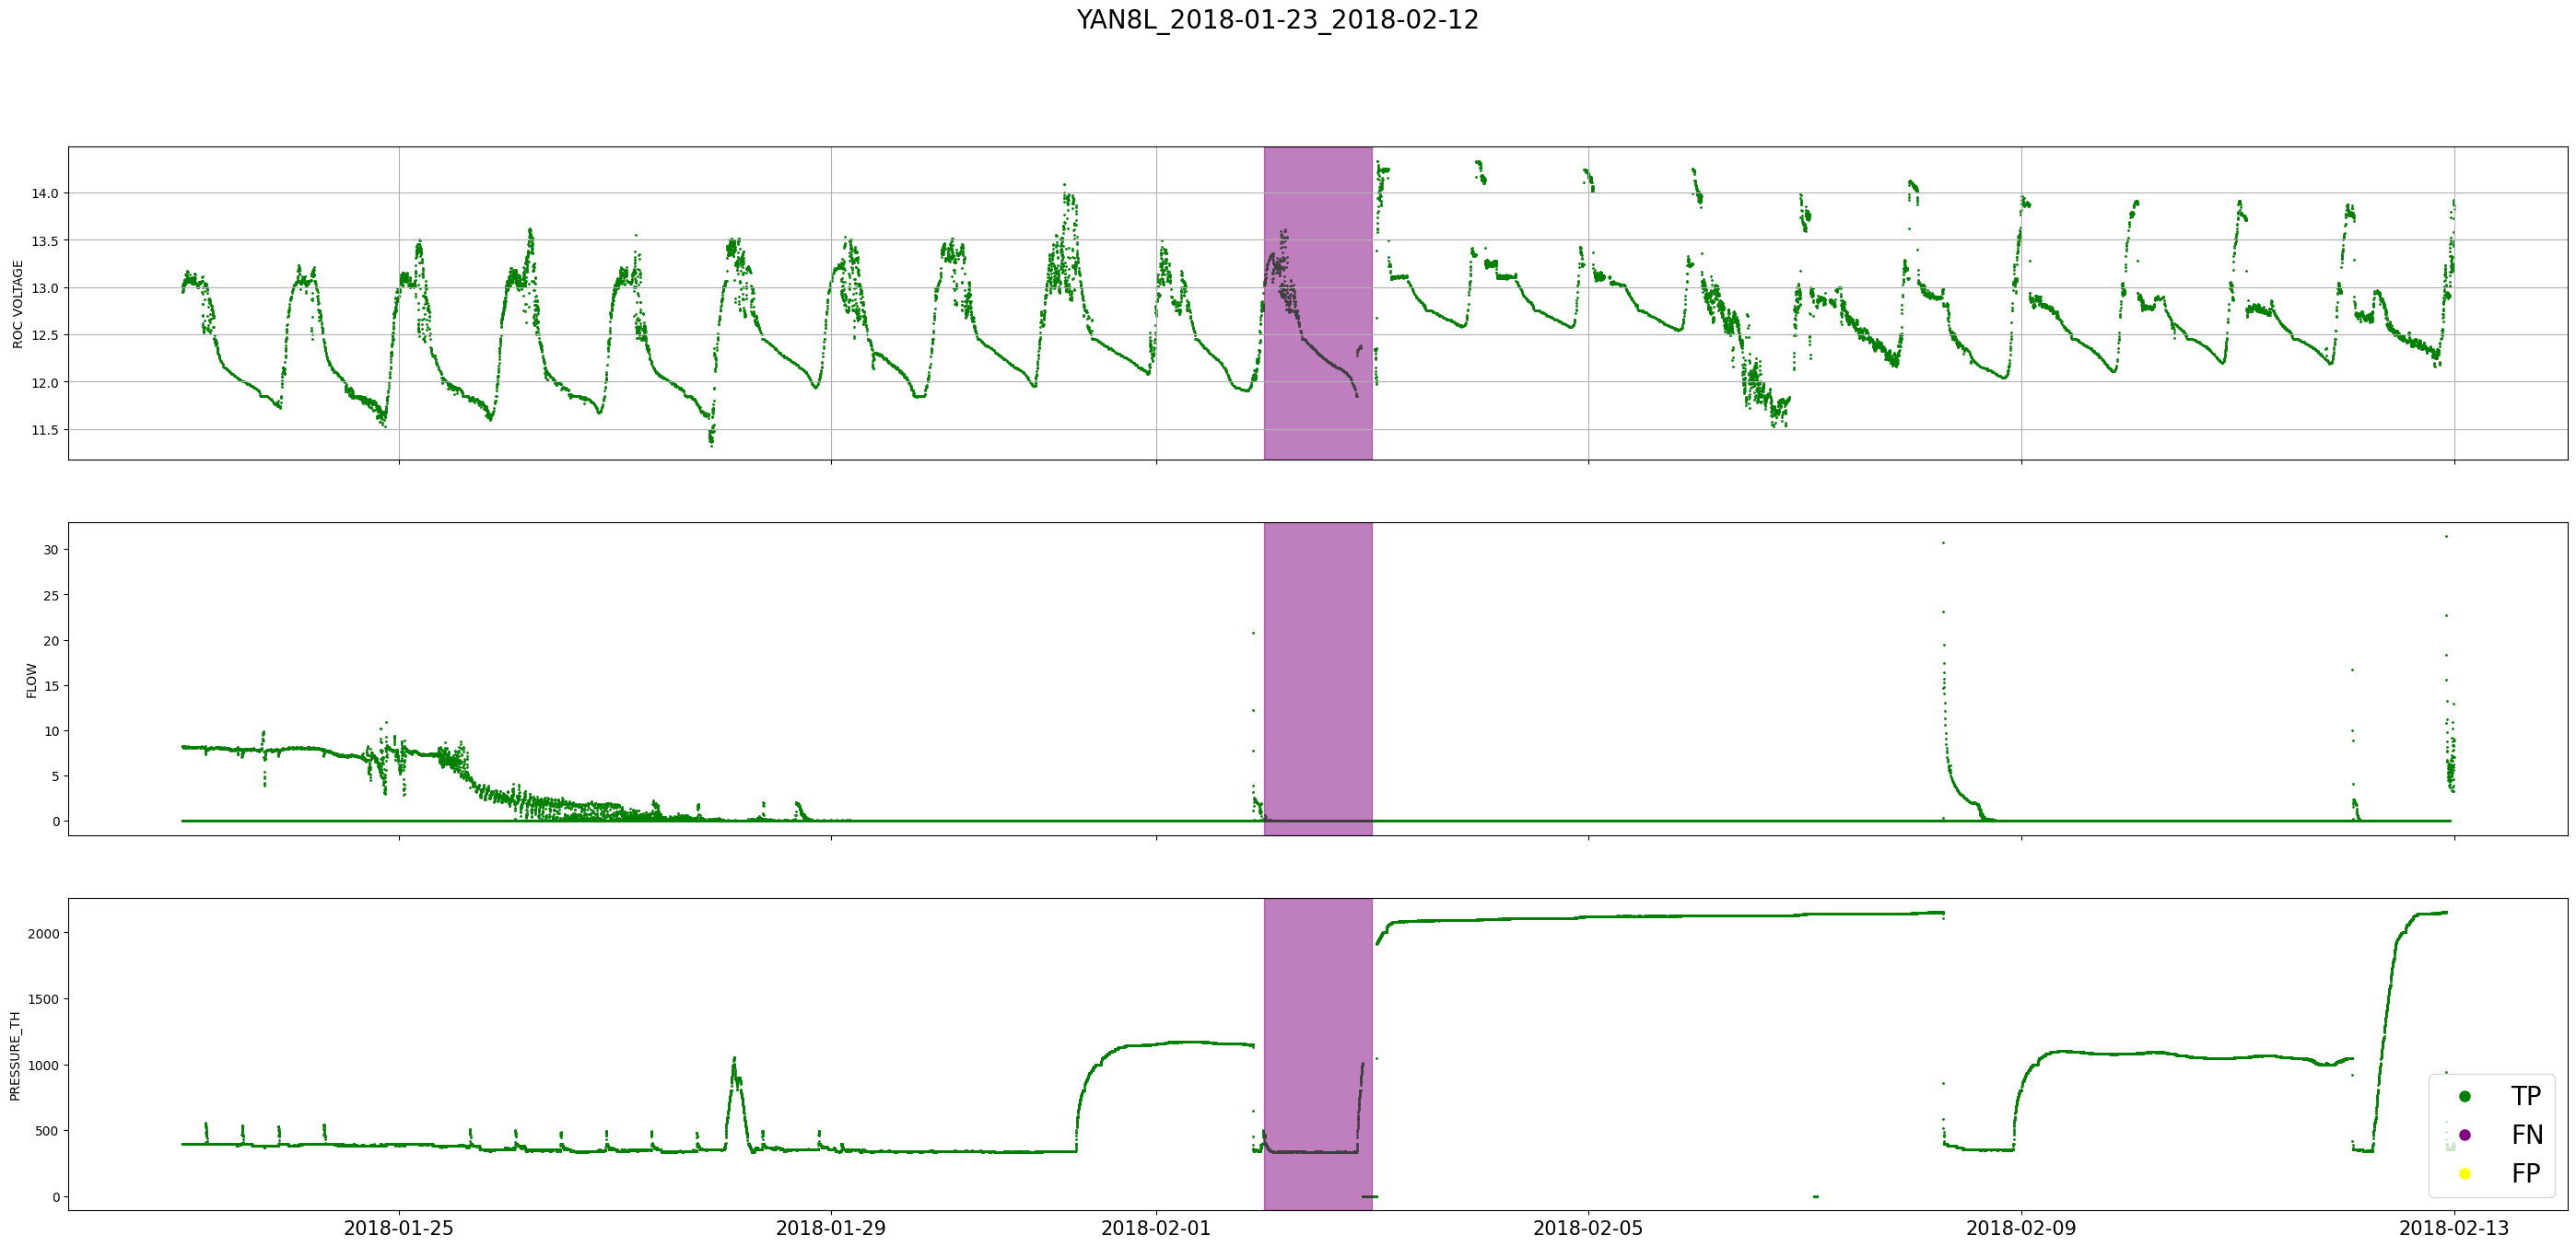

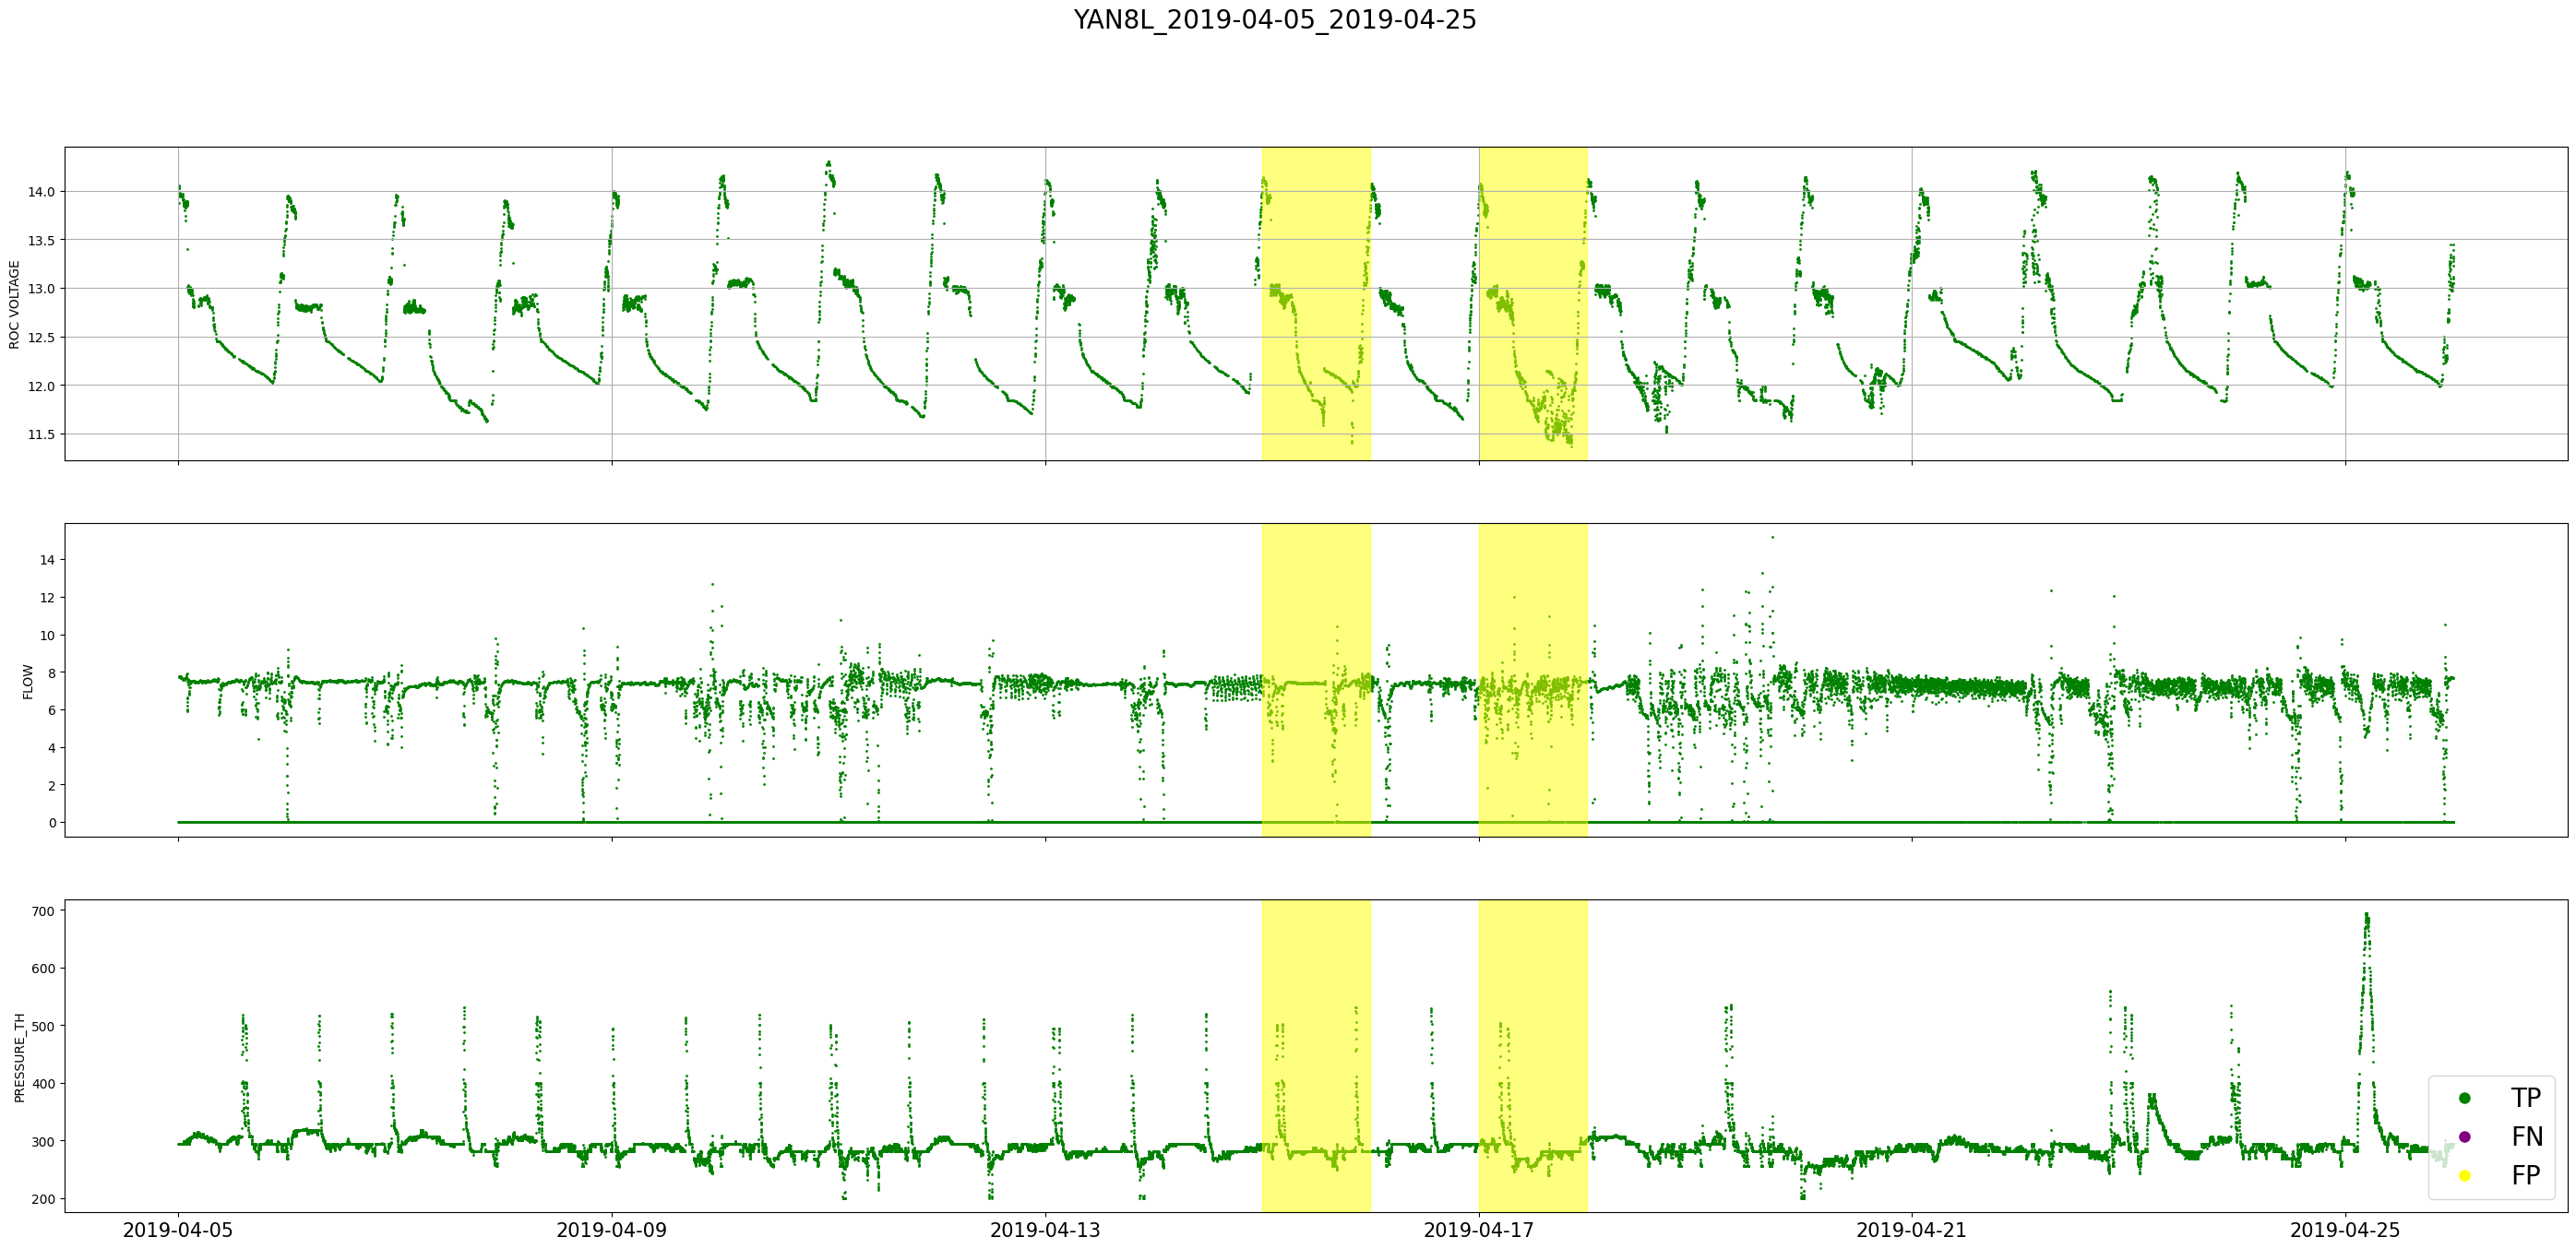

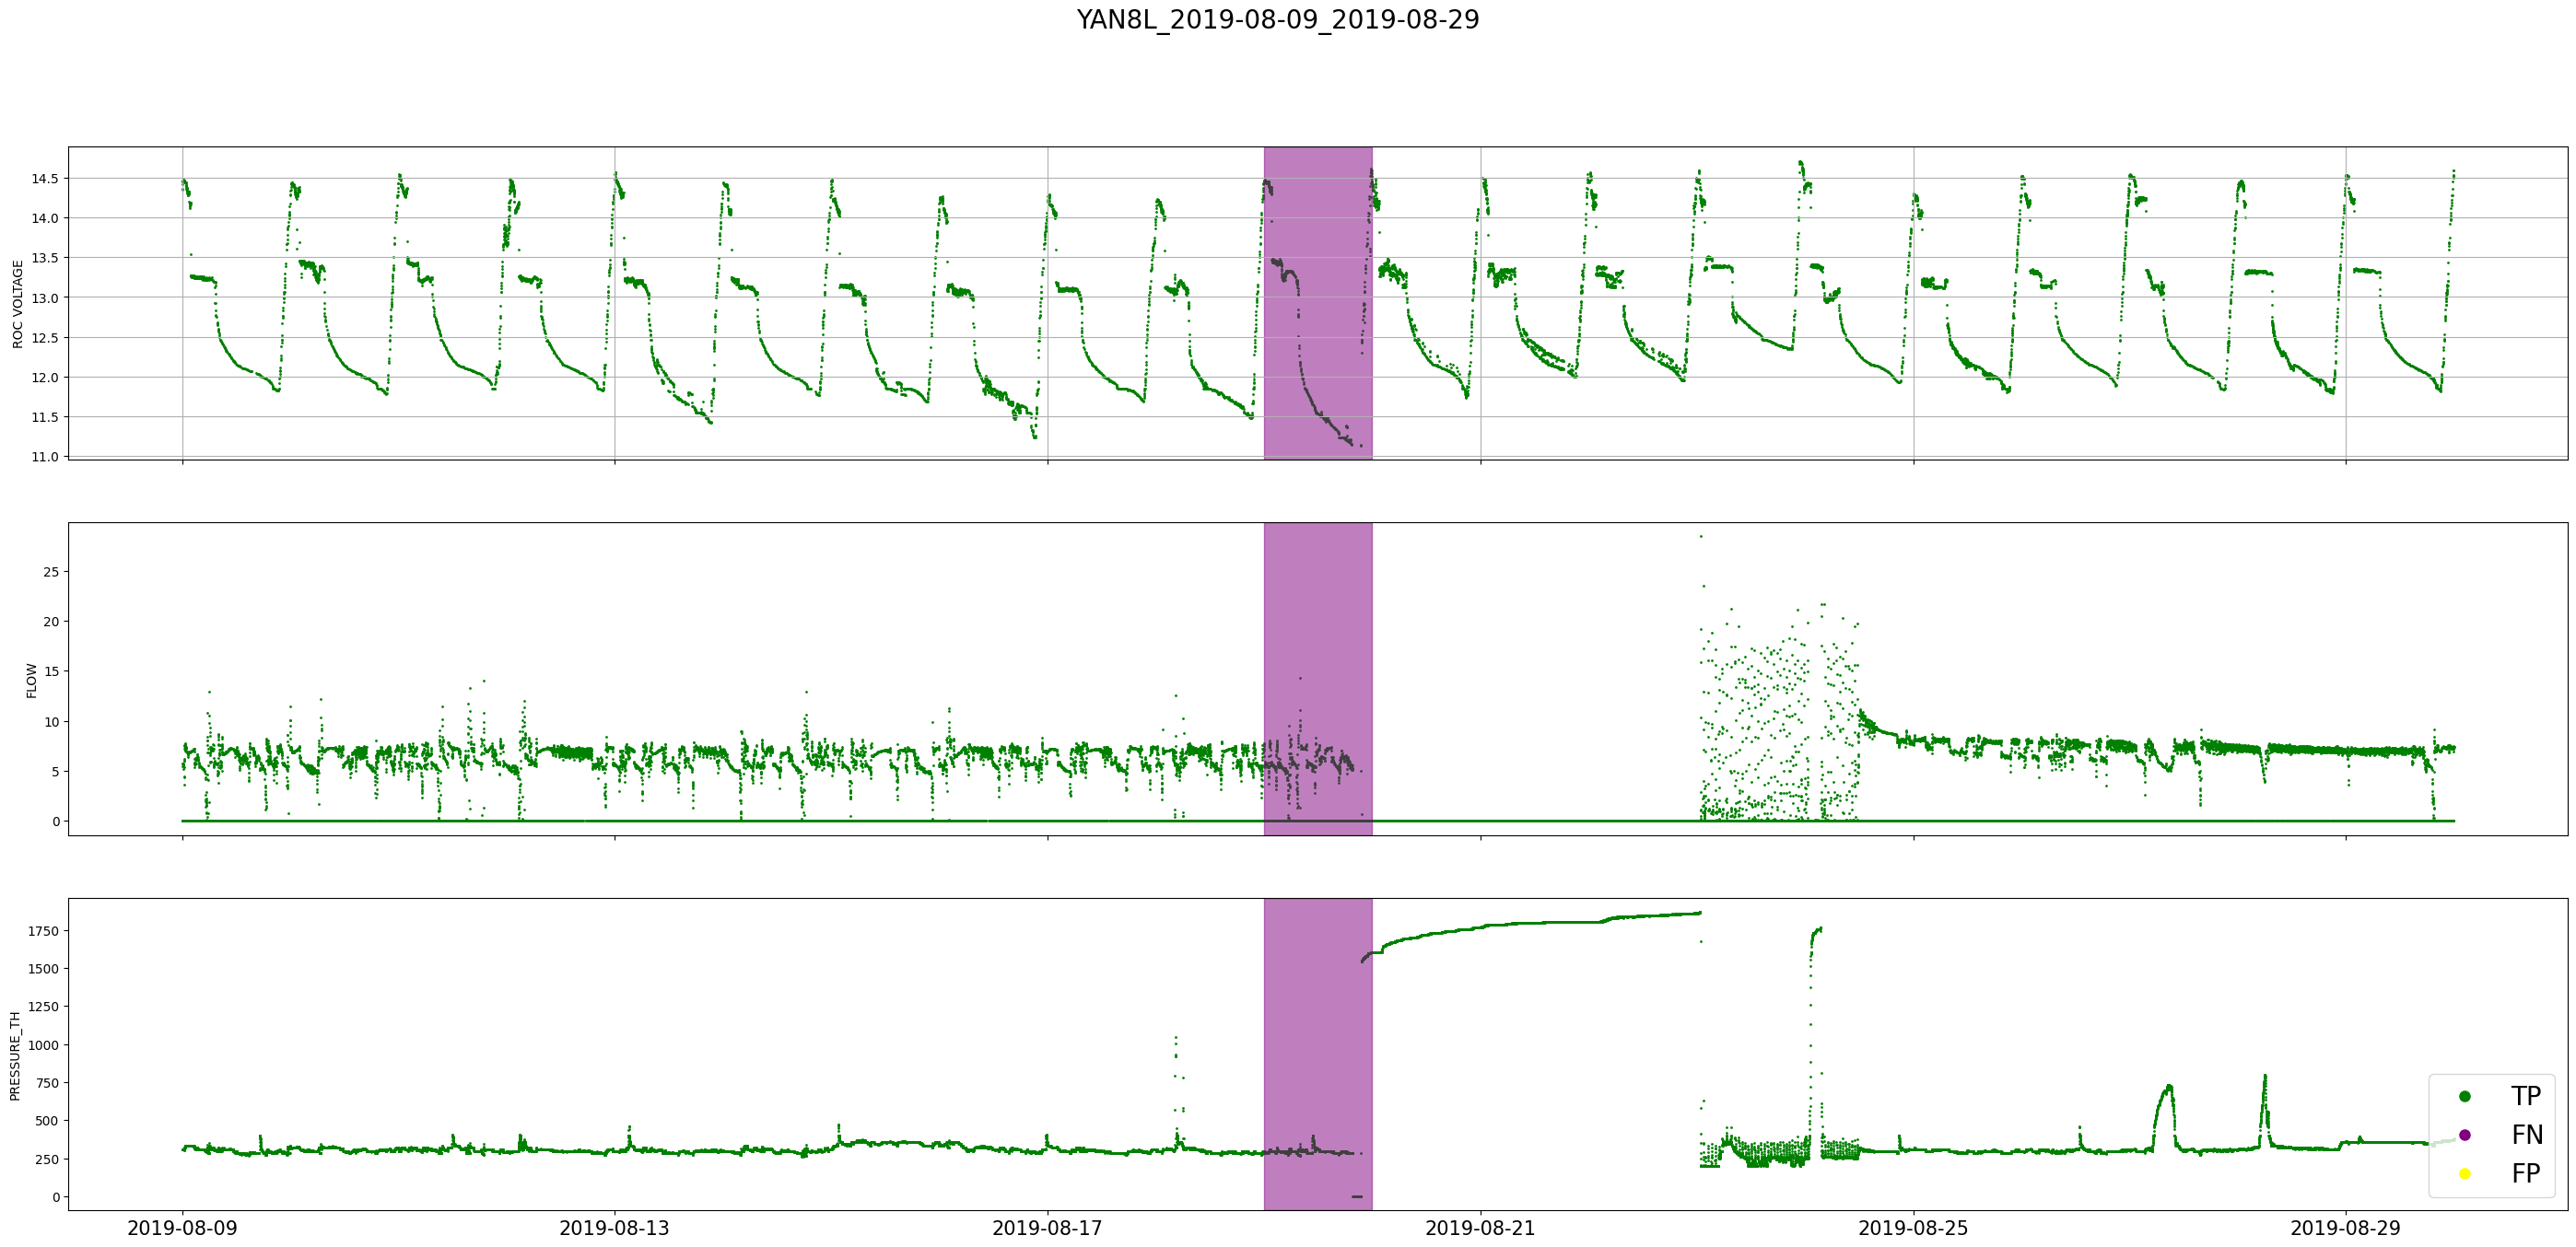

In [3]:
for well in wells:
    model = FeatureExtractor(well)
    print(f"Processing well: {well}")
    model.get_diagnostic_plots("min_VOLTAGE")

Processing well: YAN8L


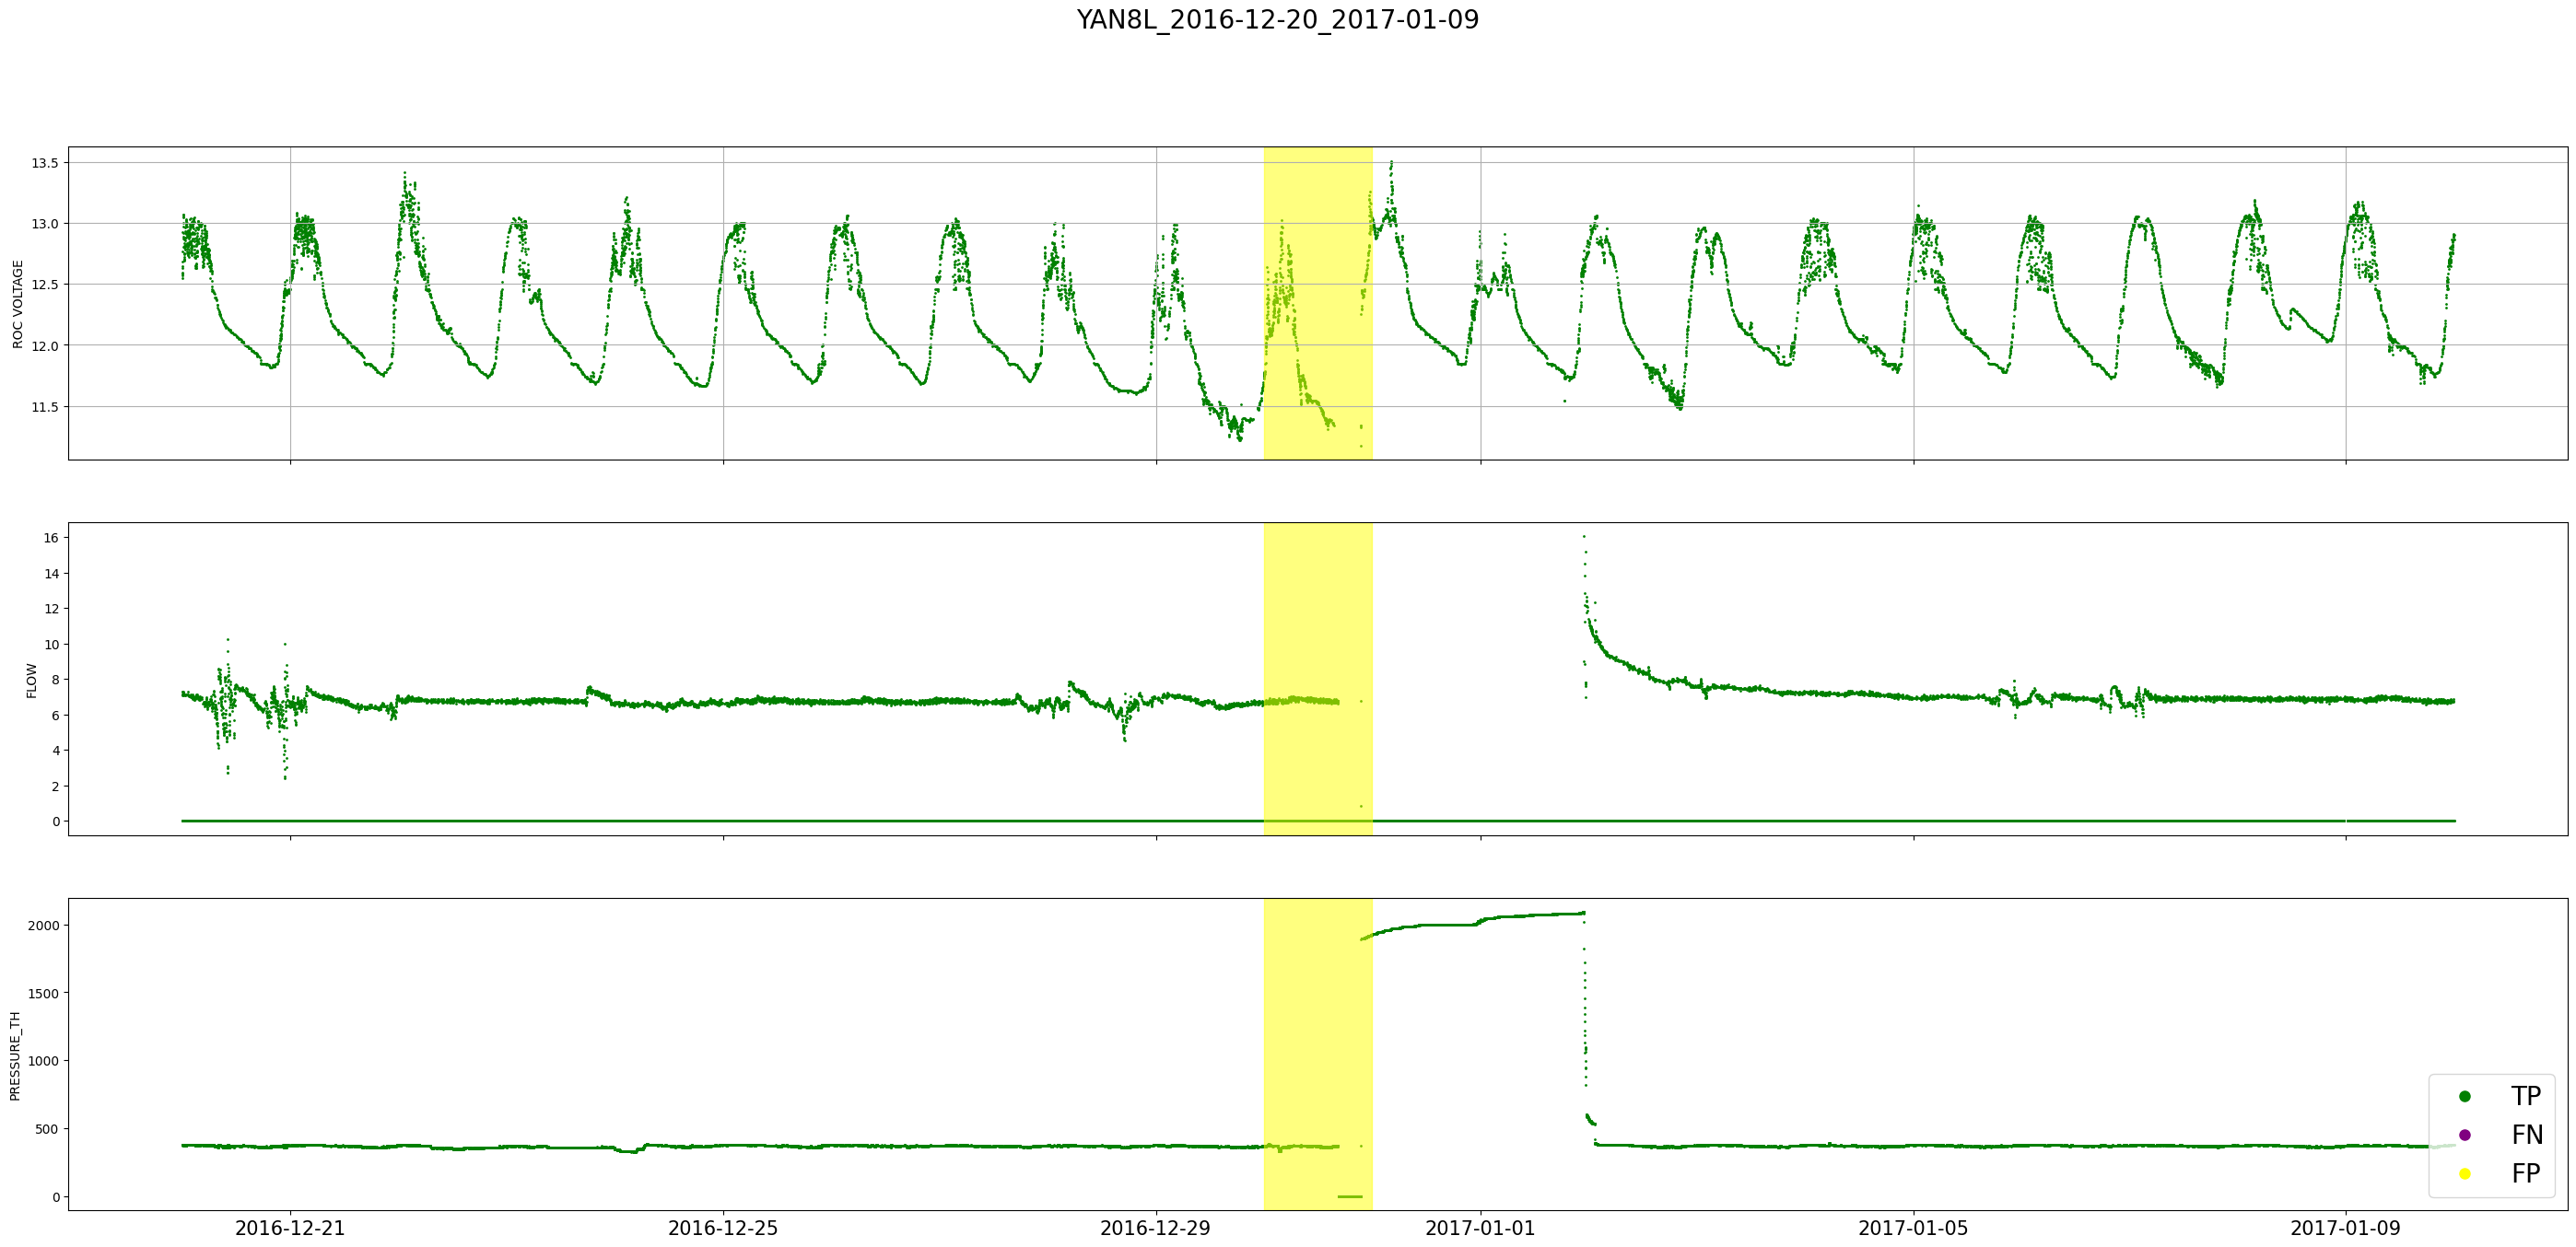

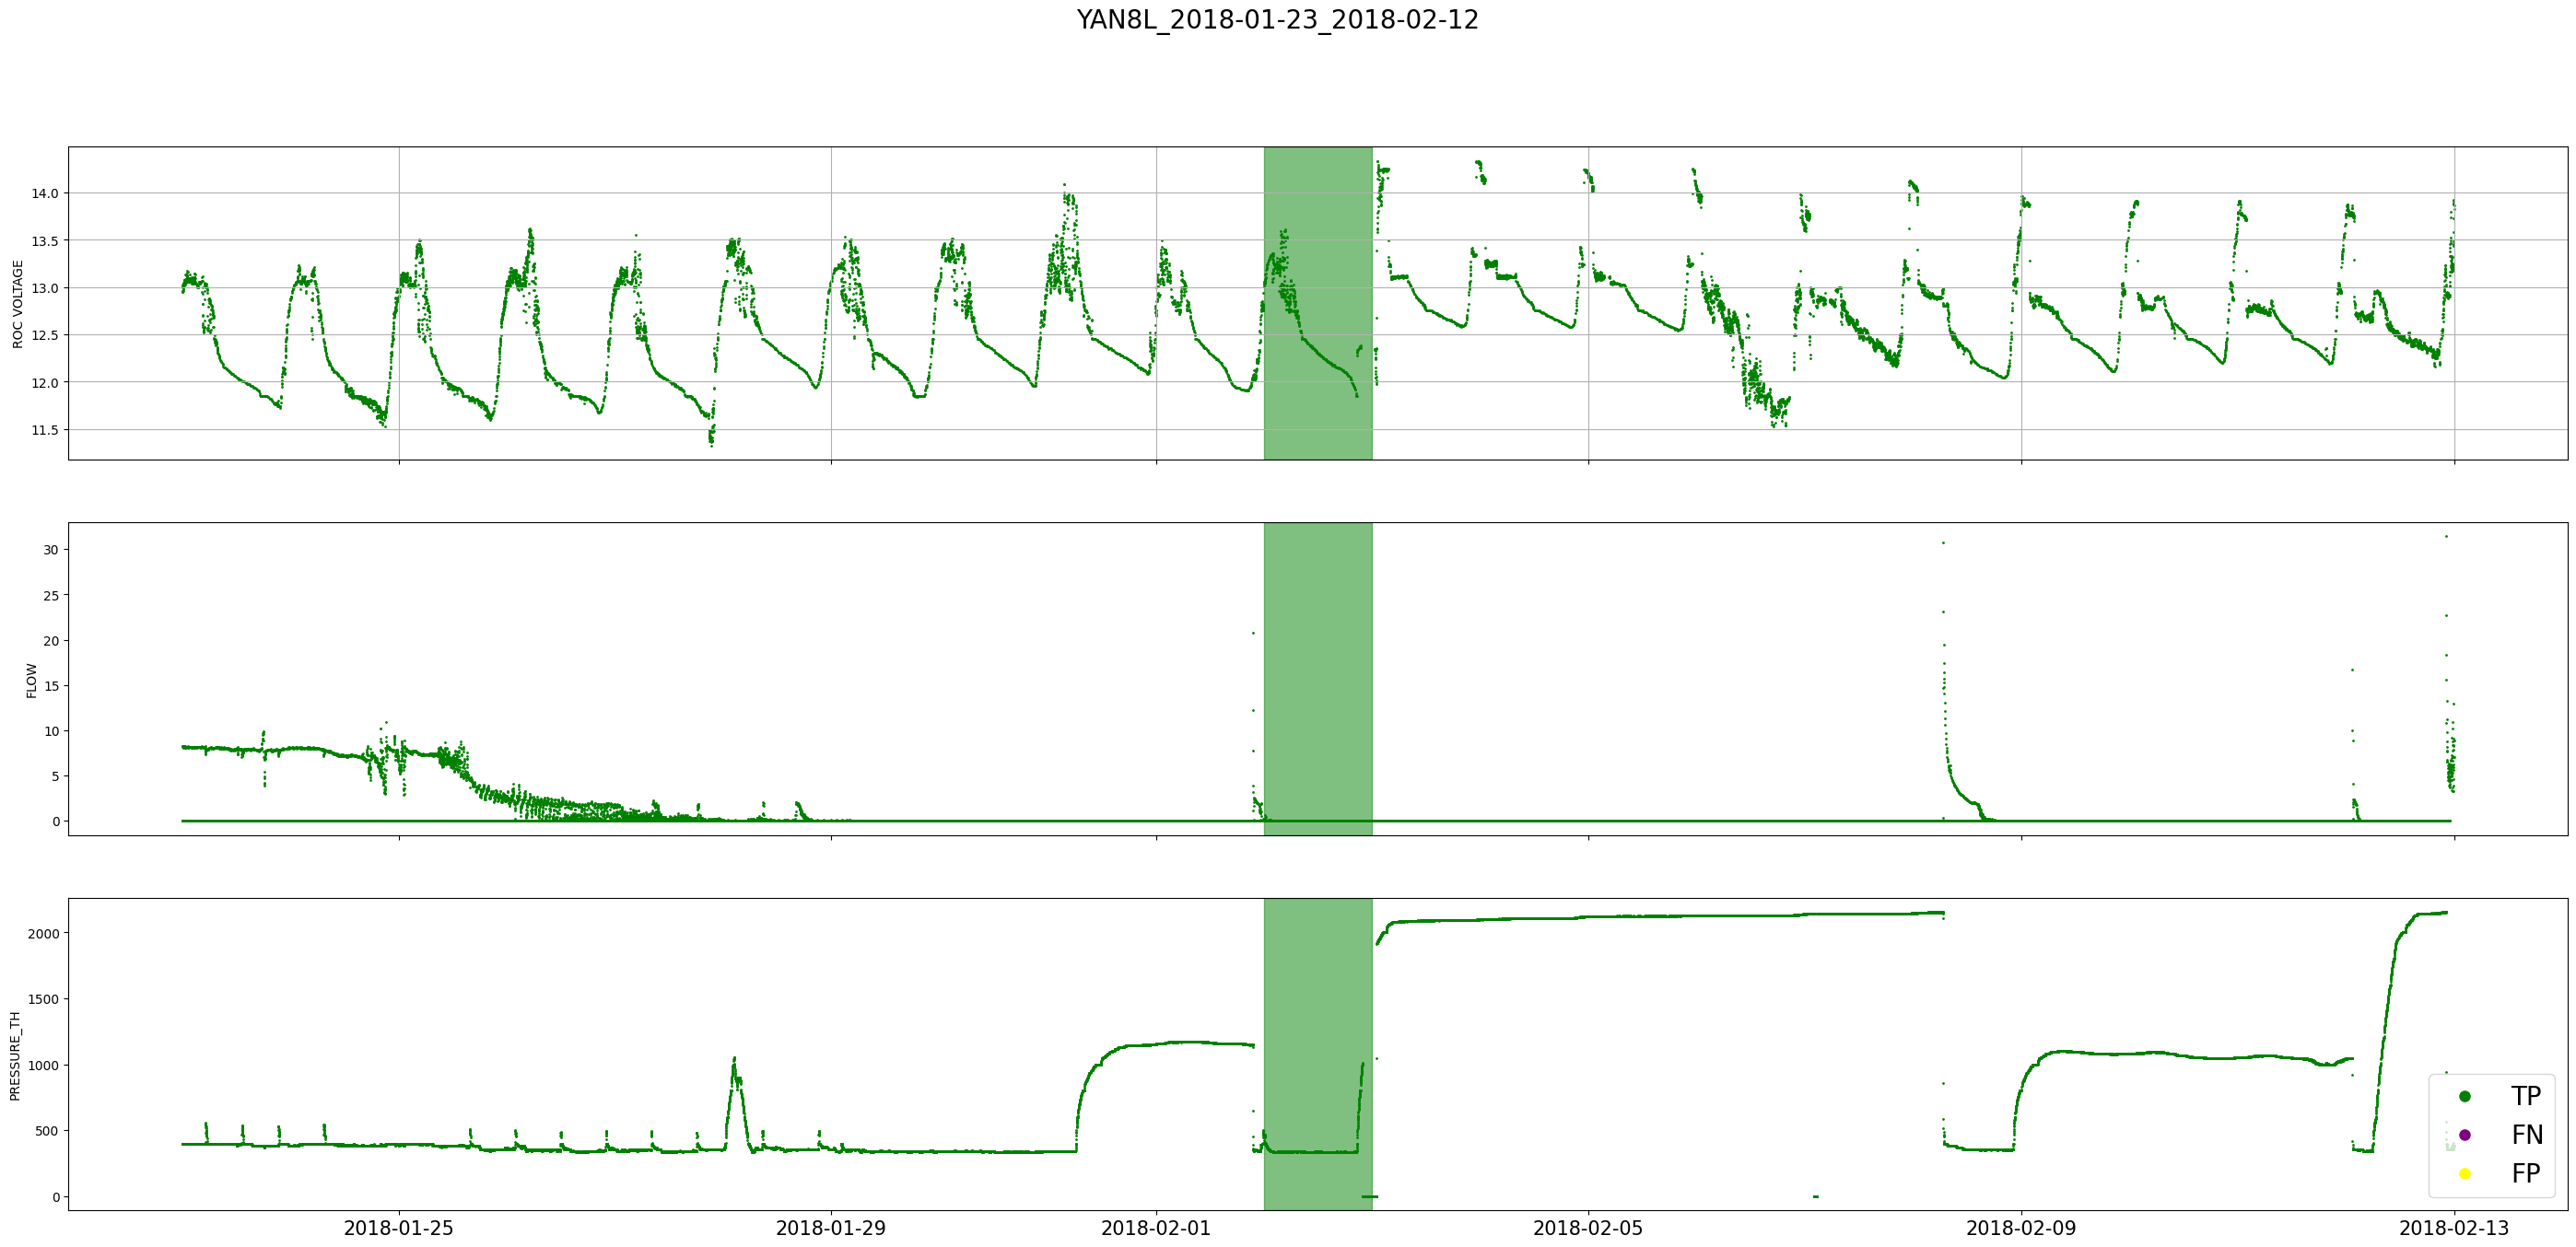

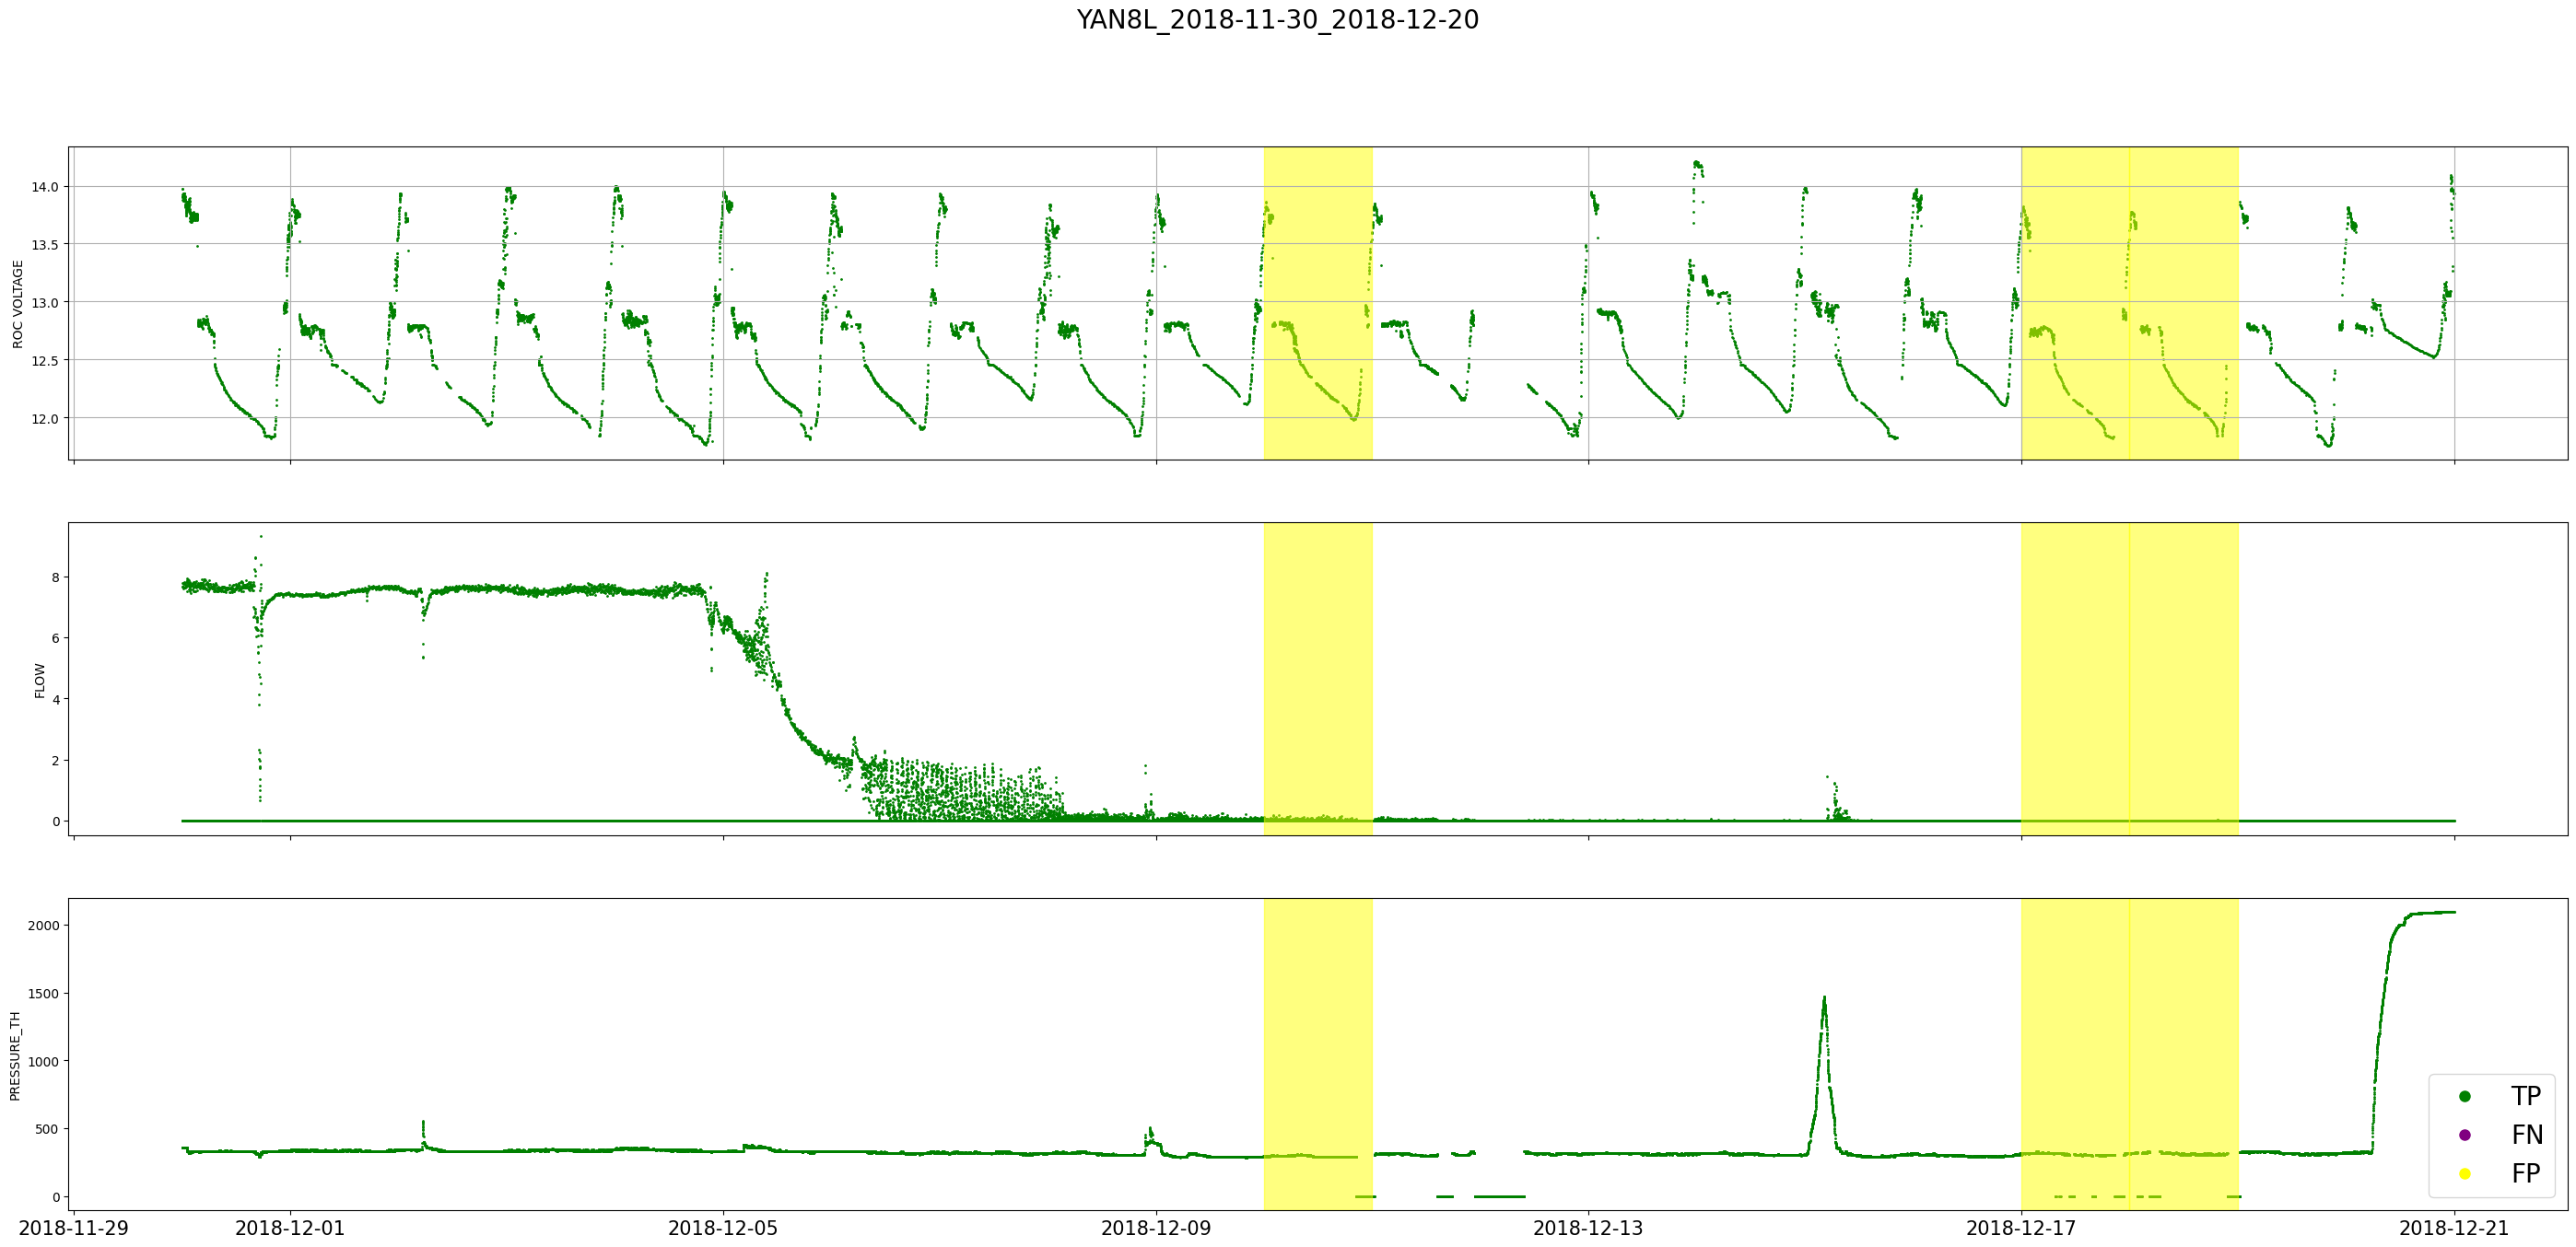

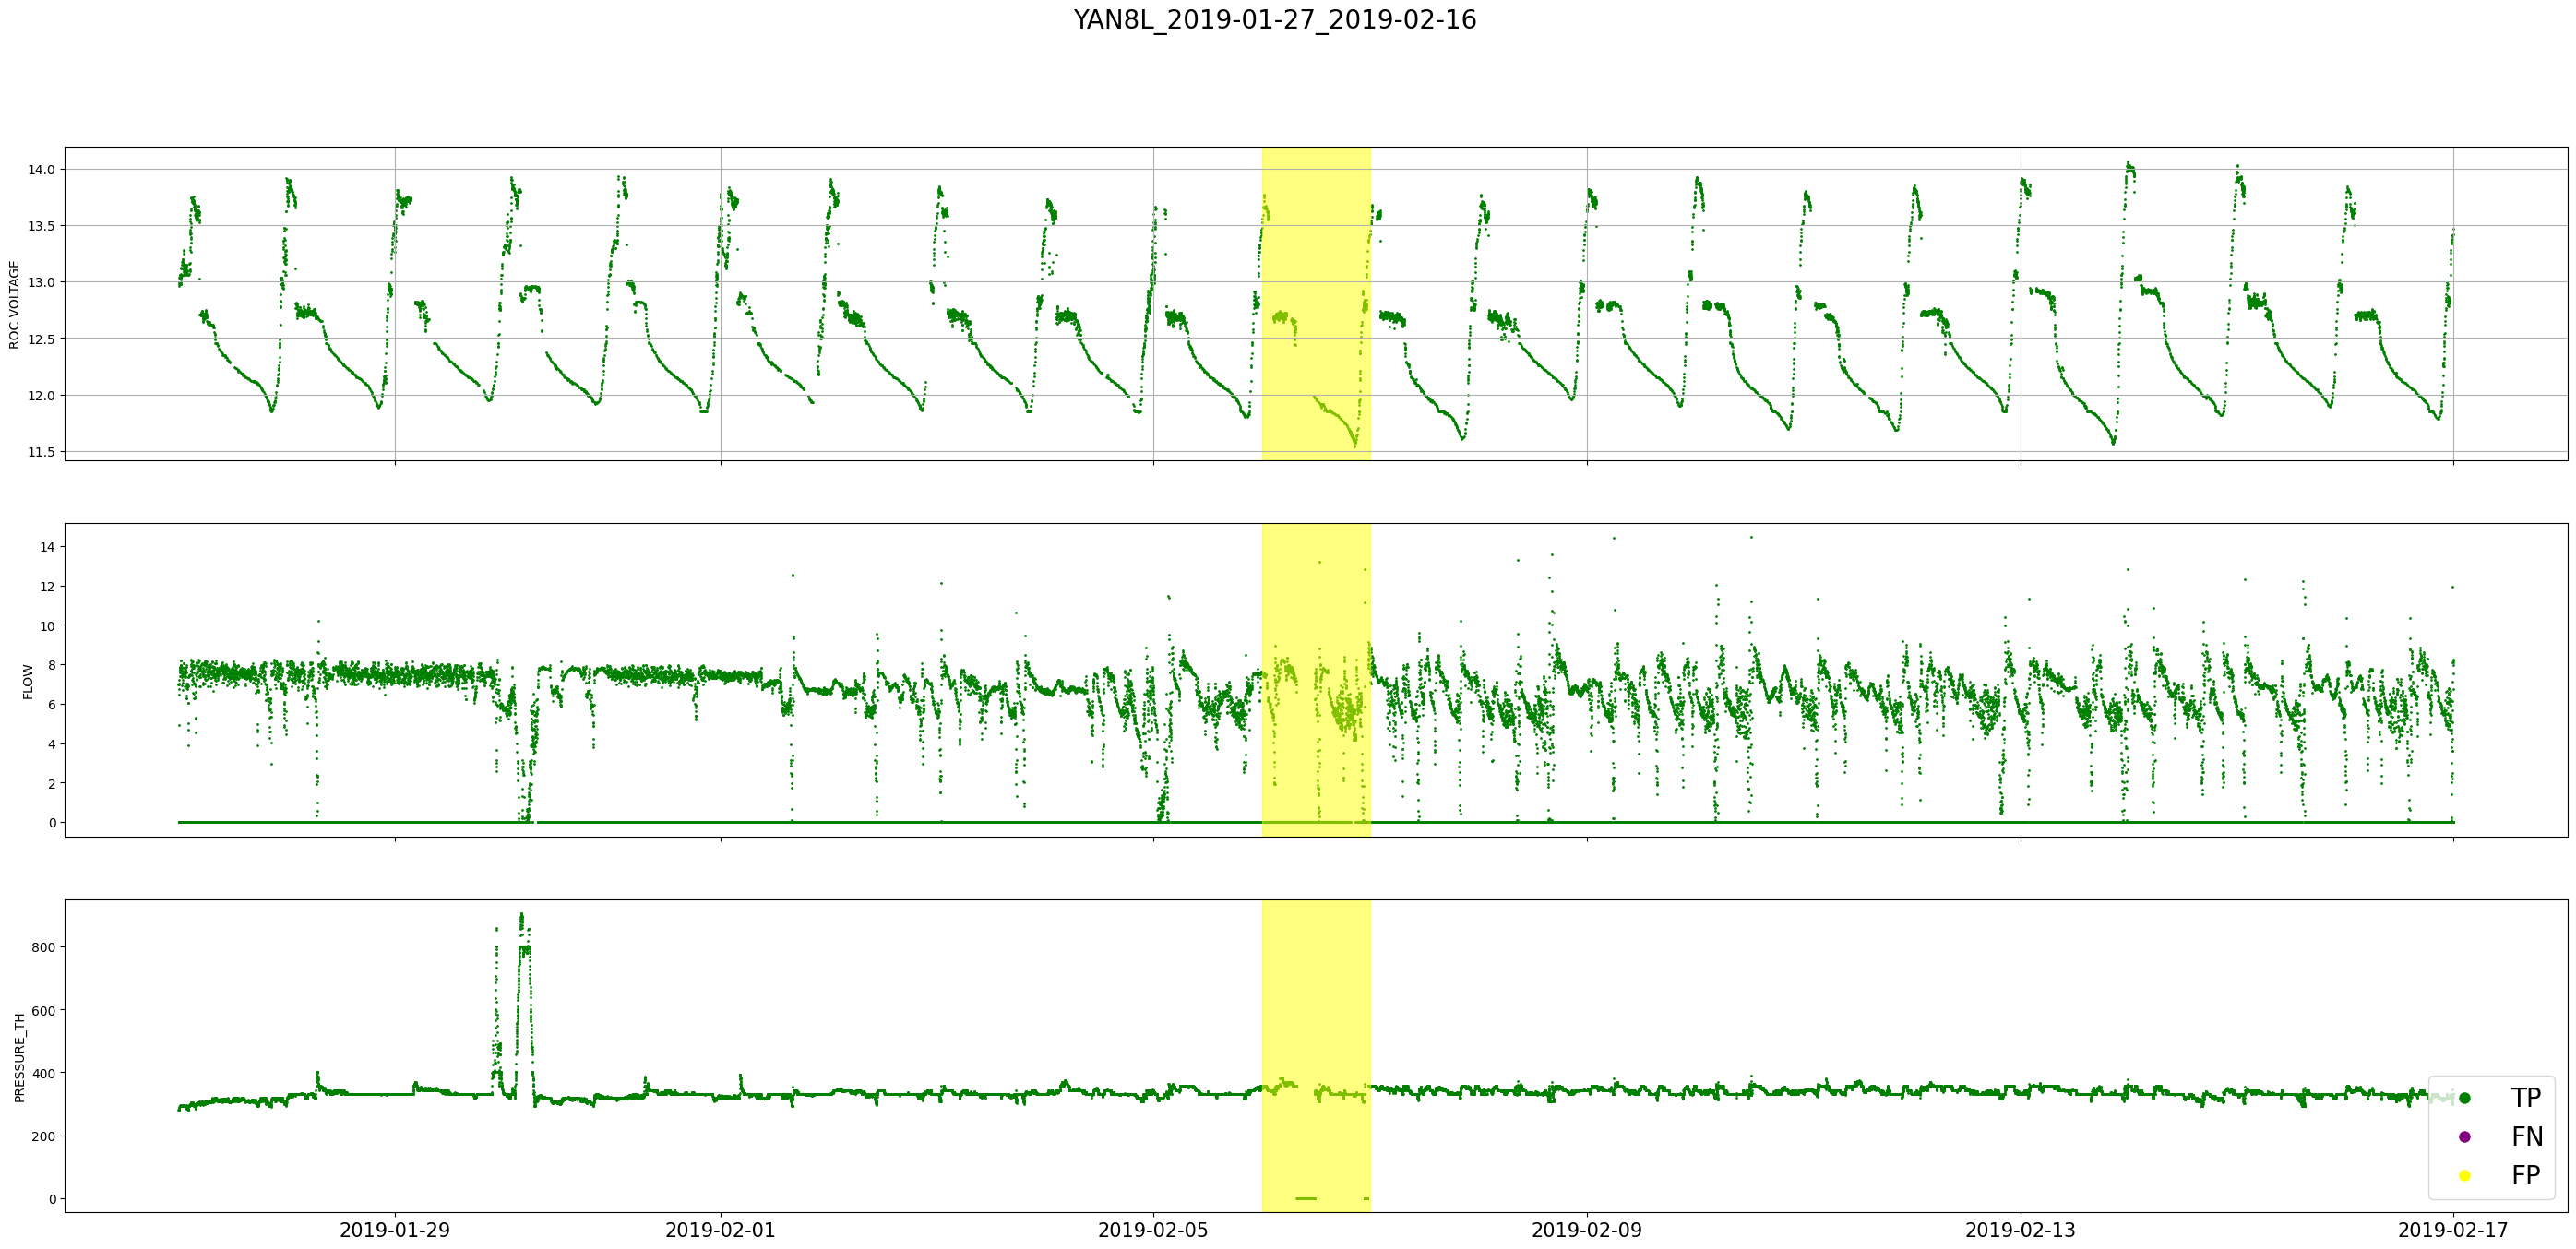

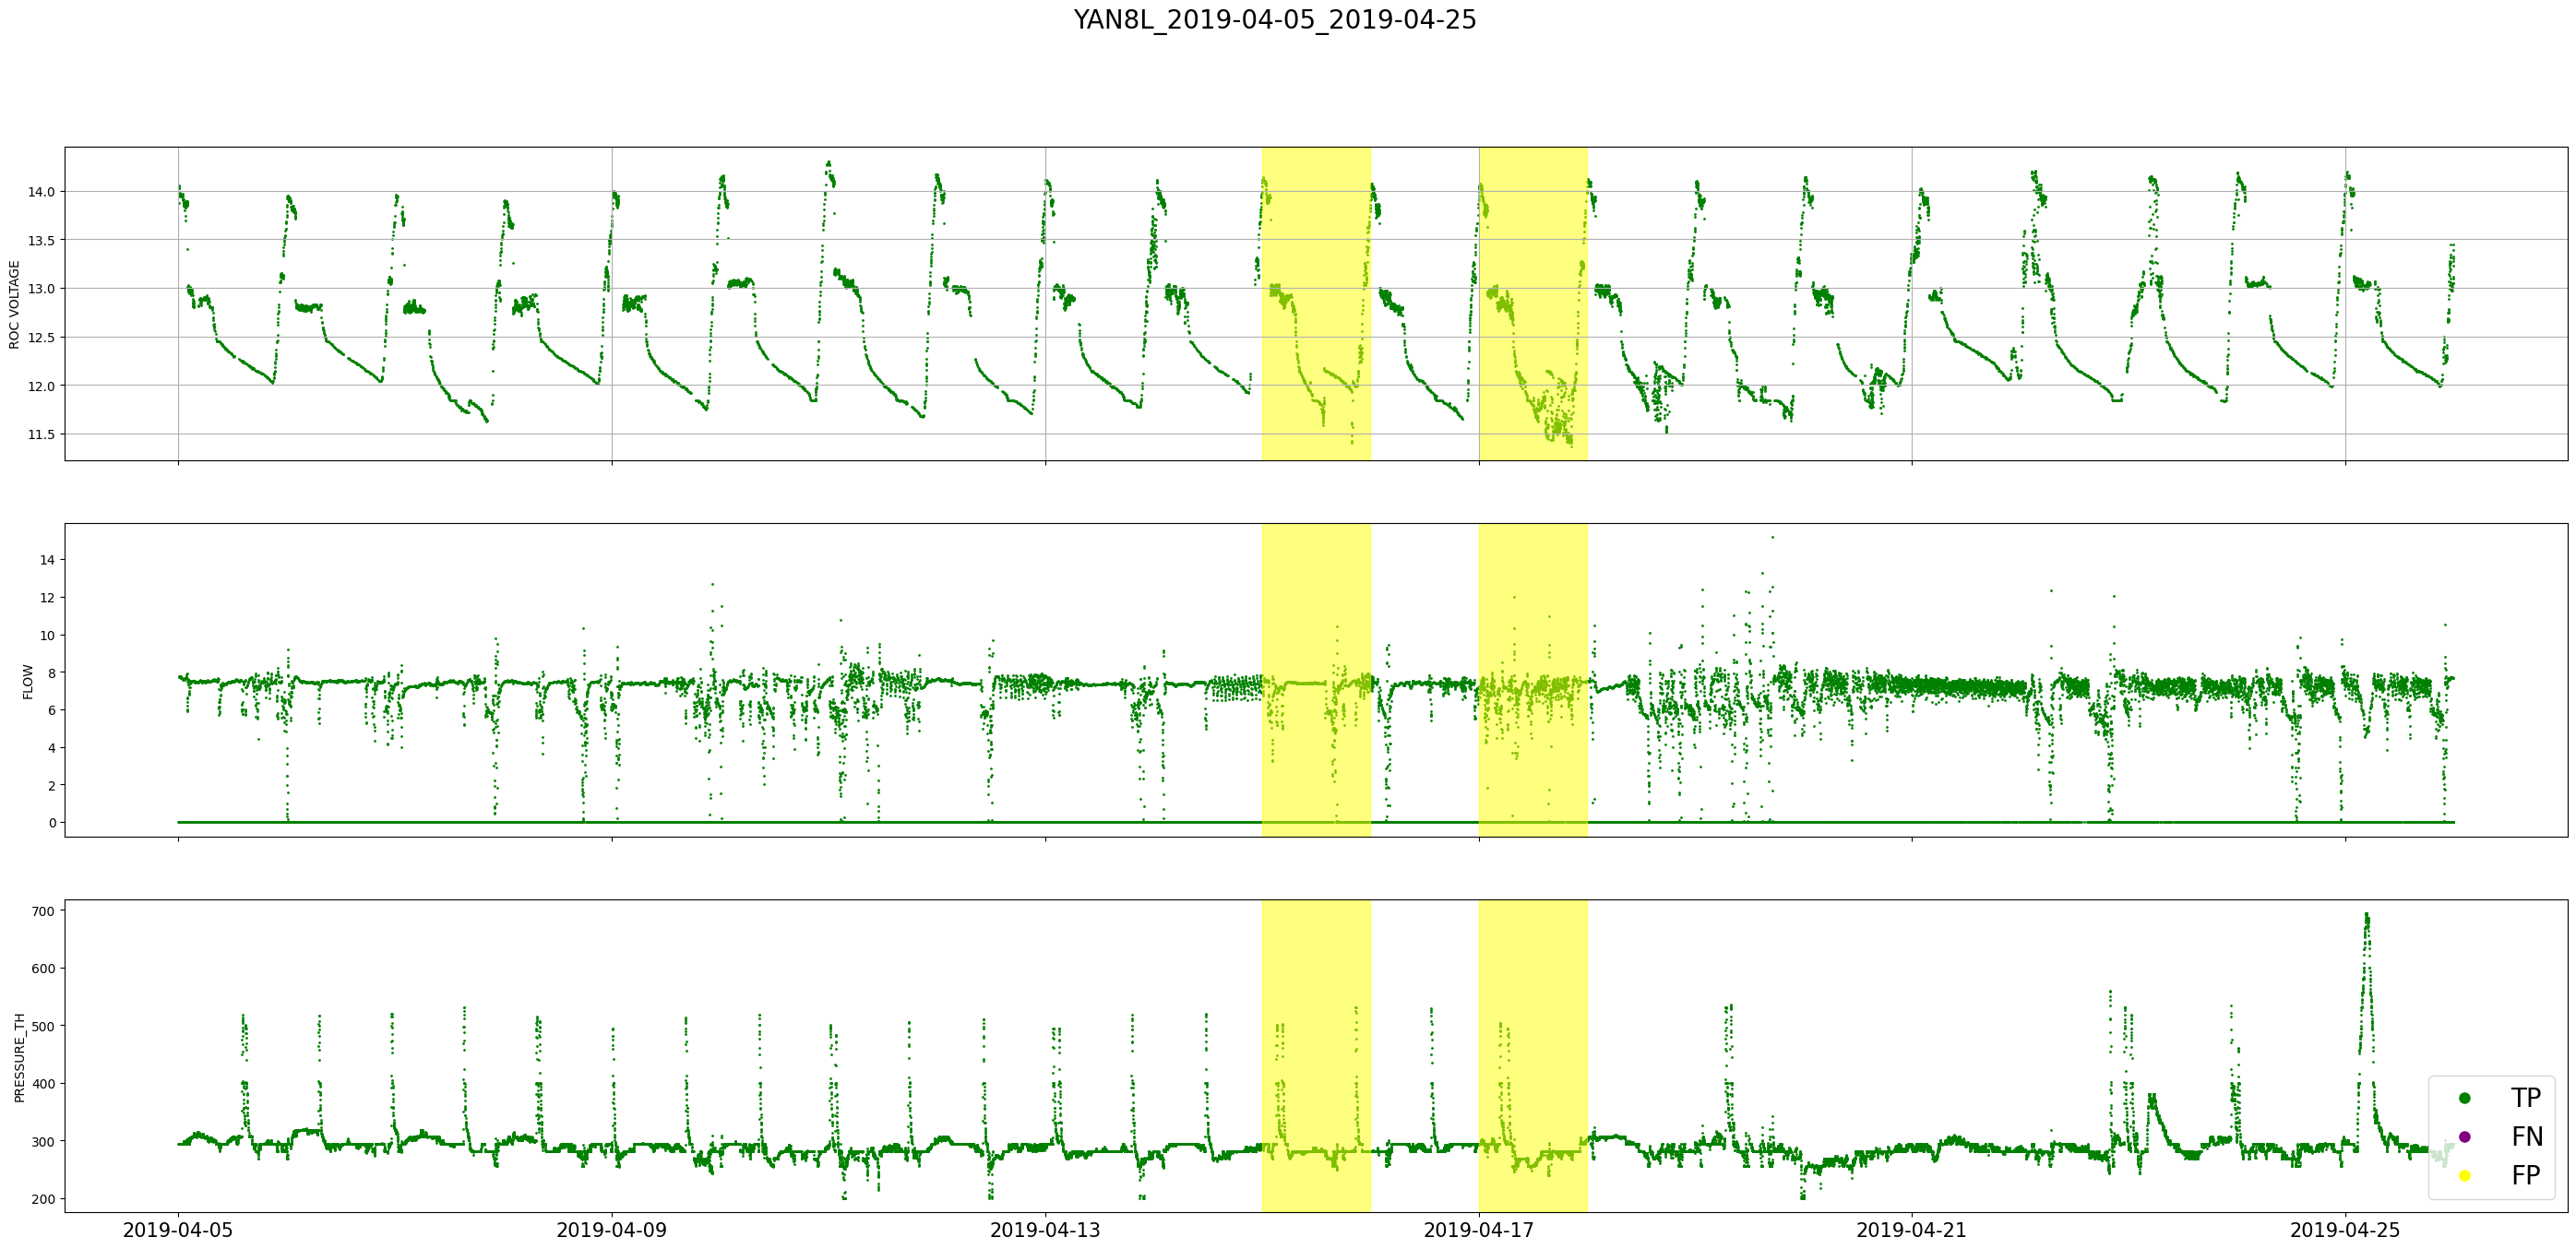

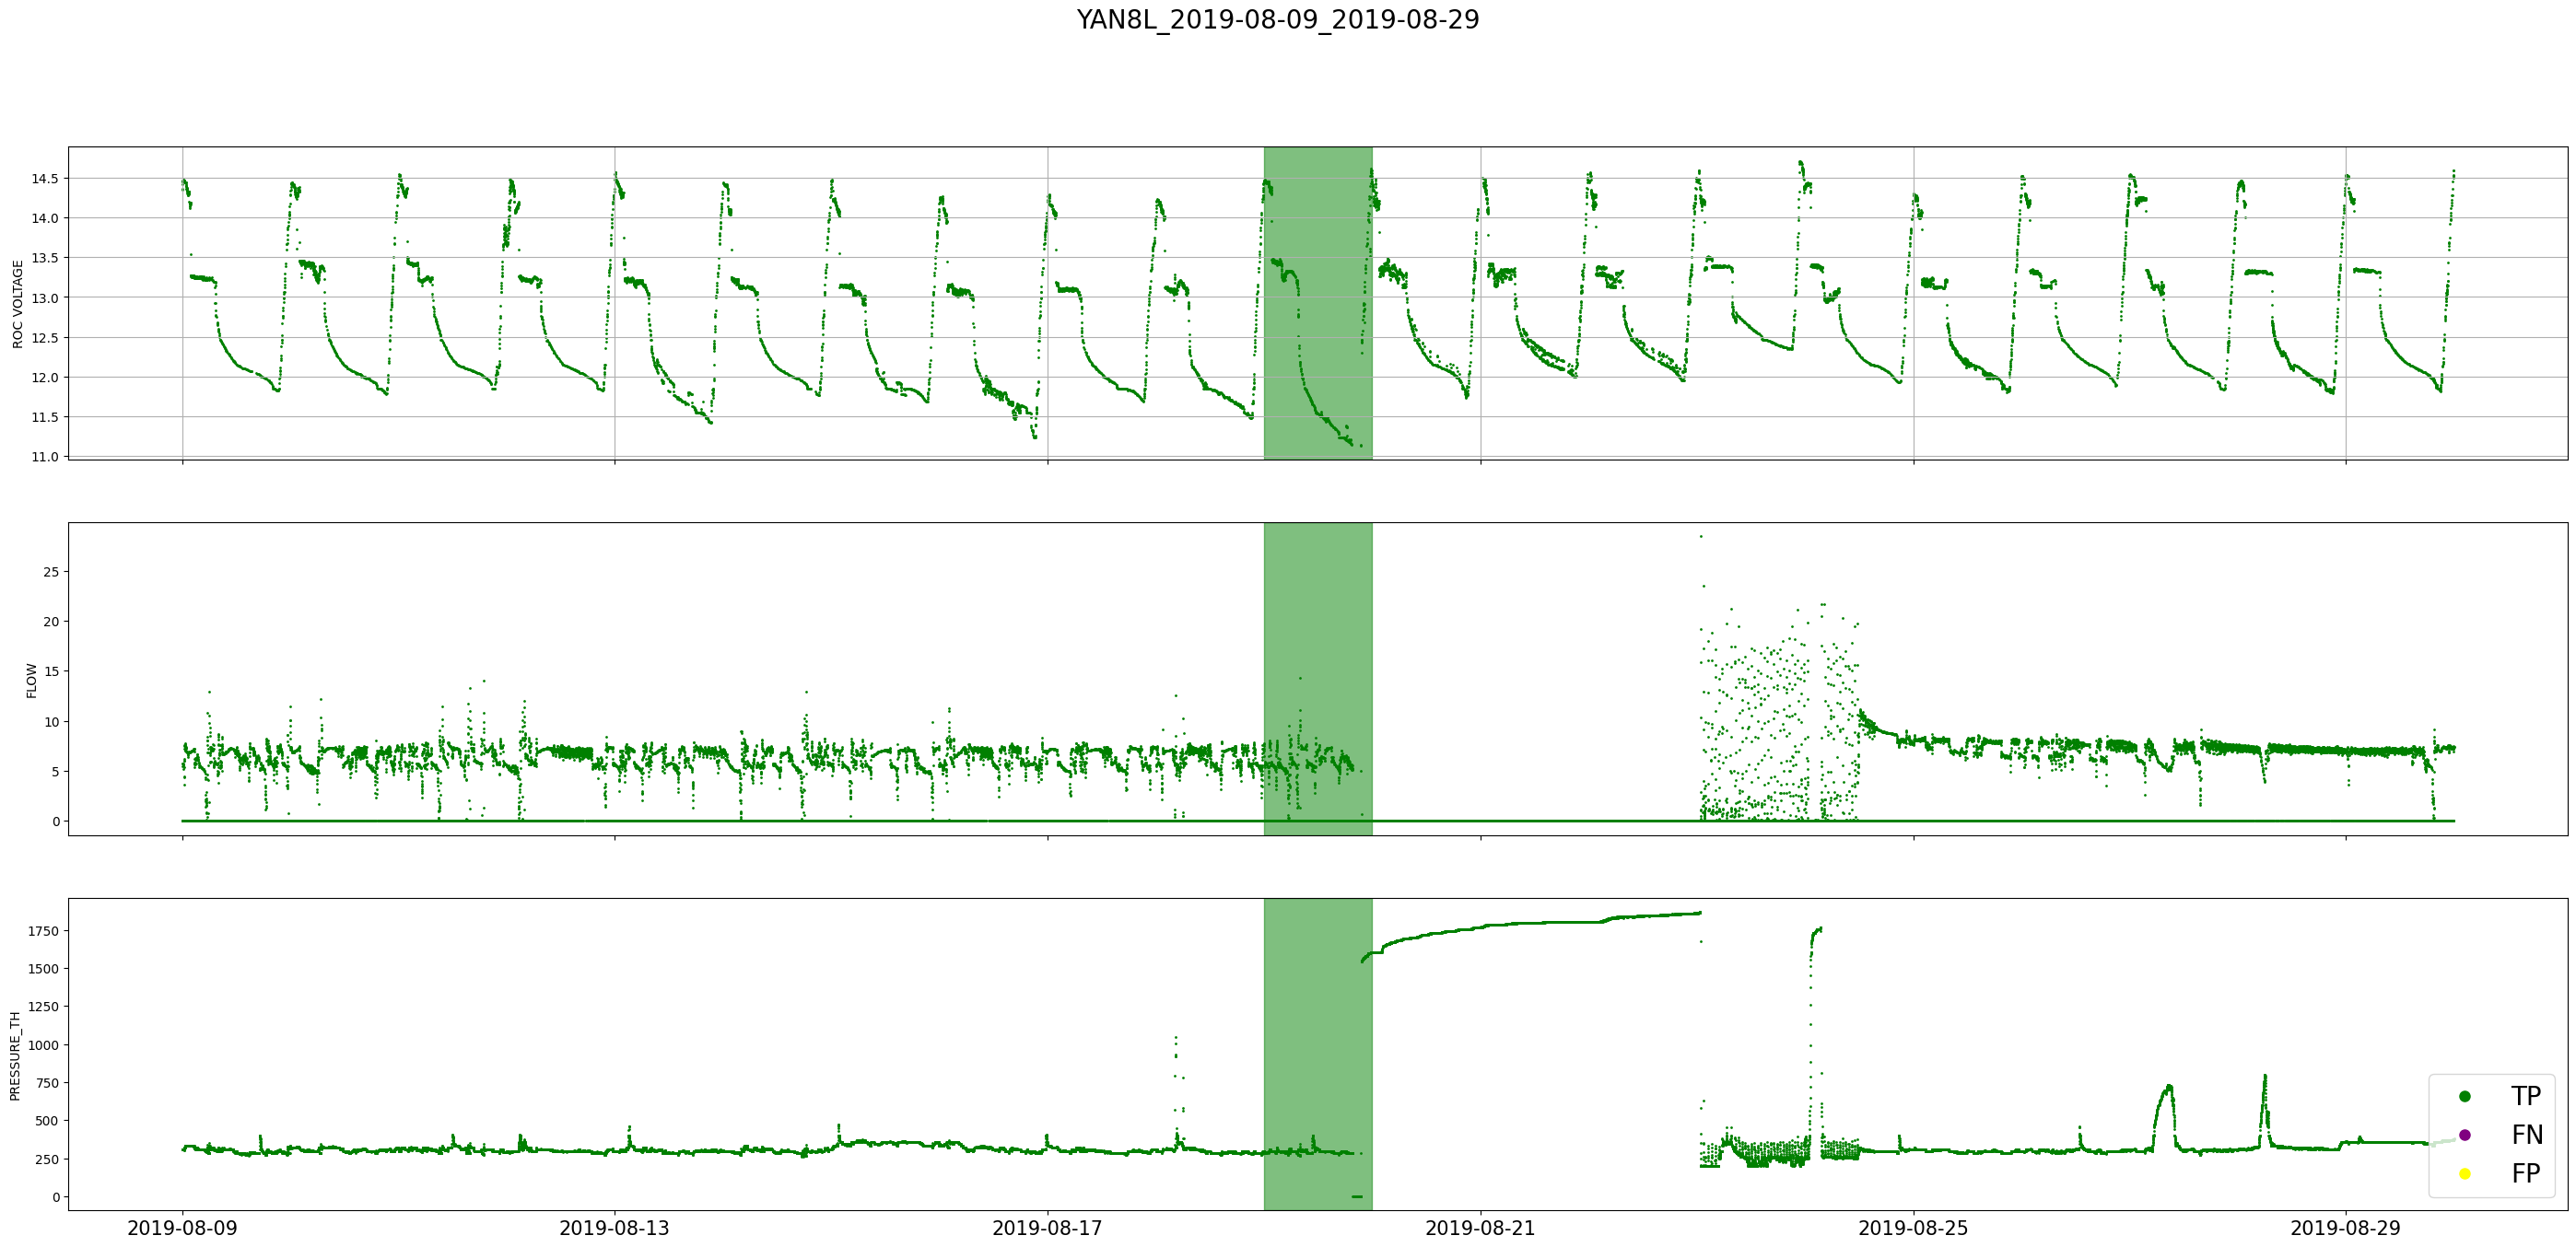

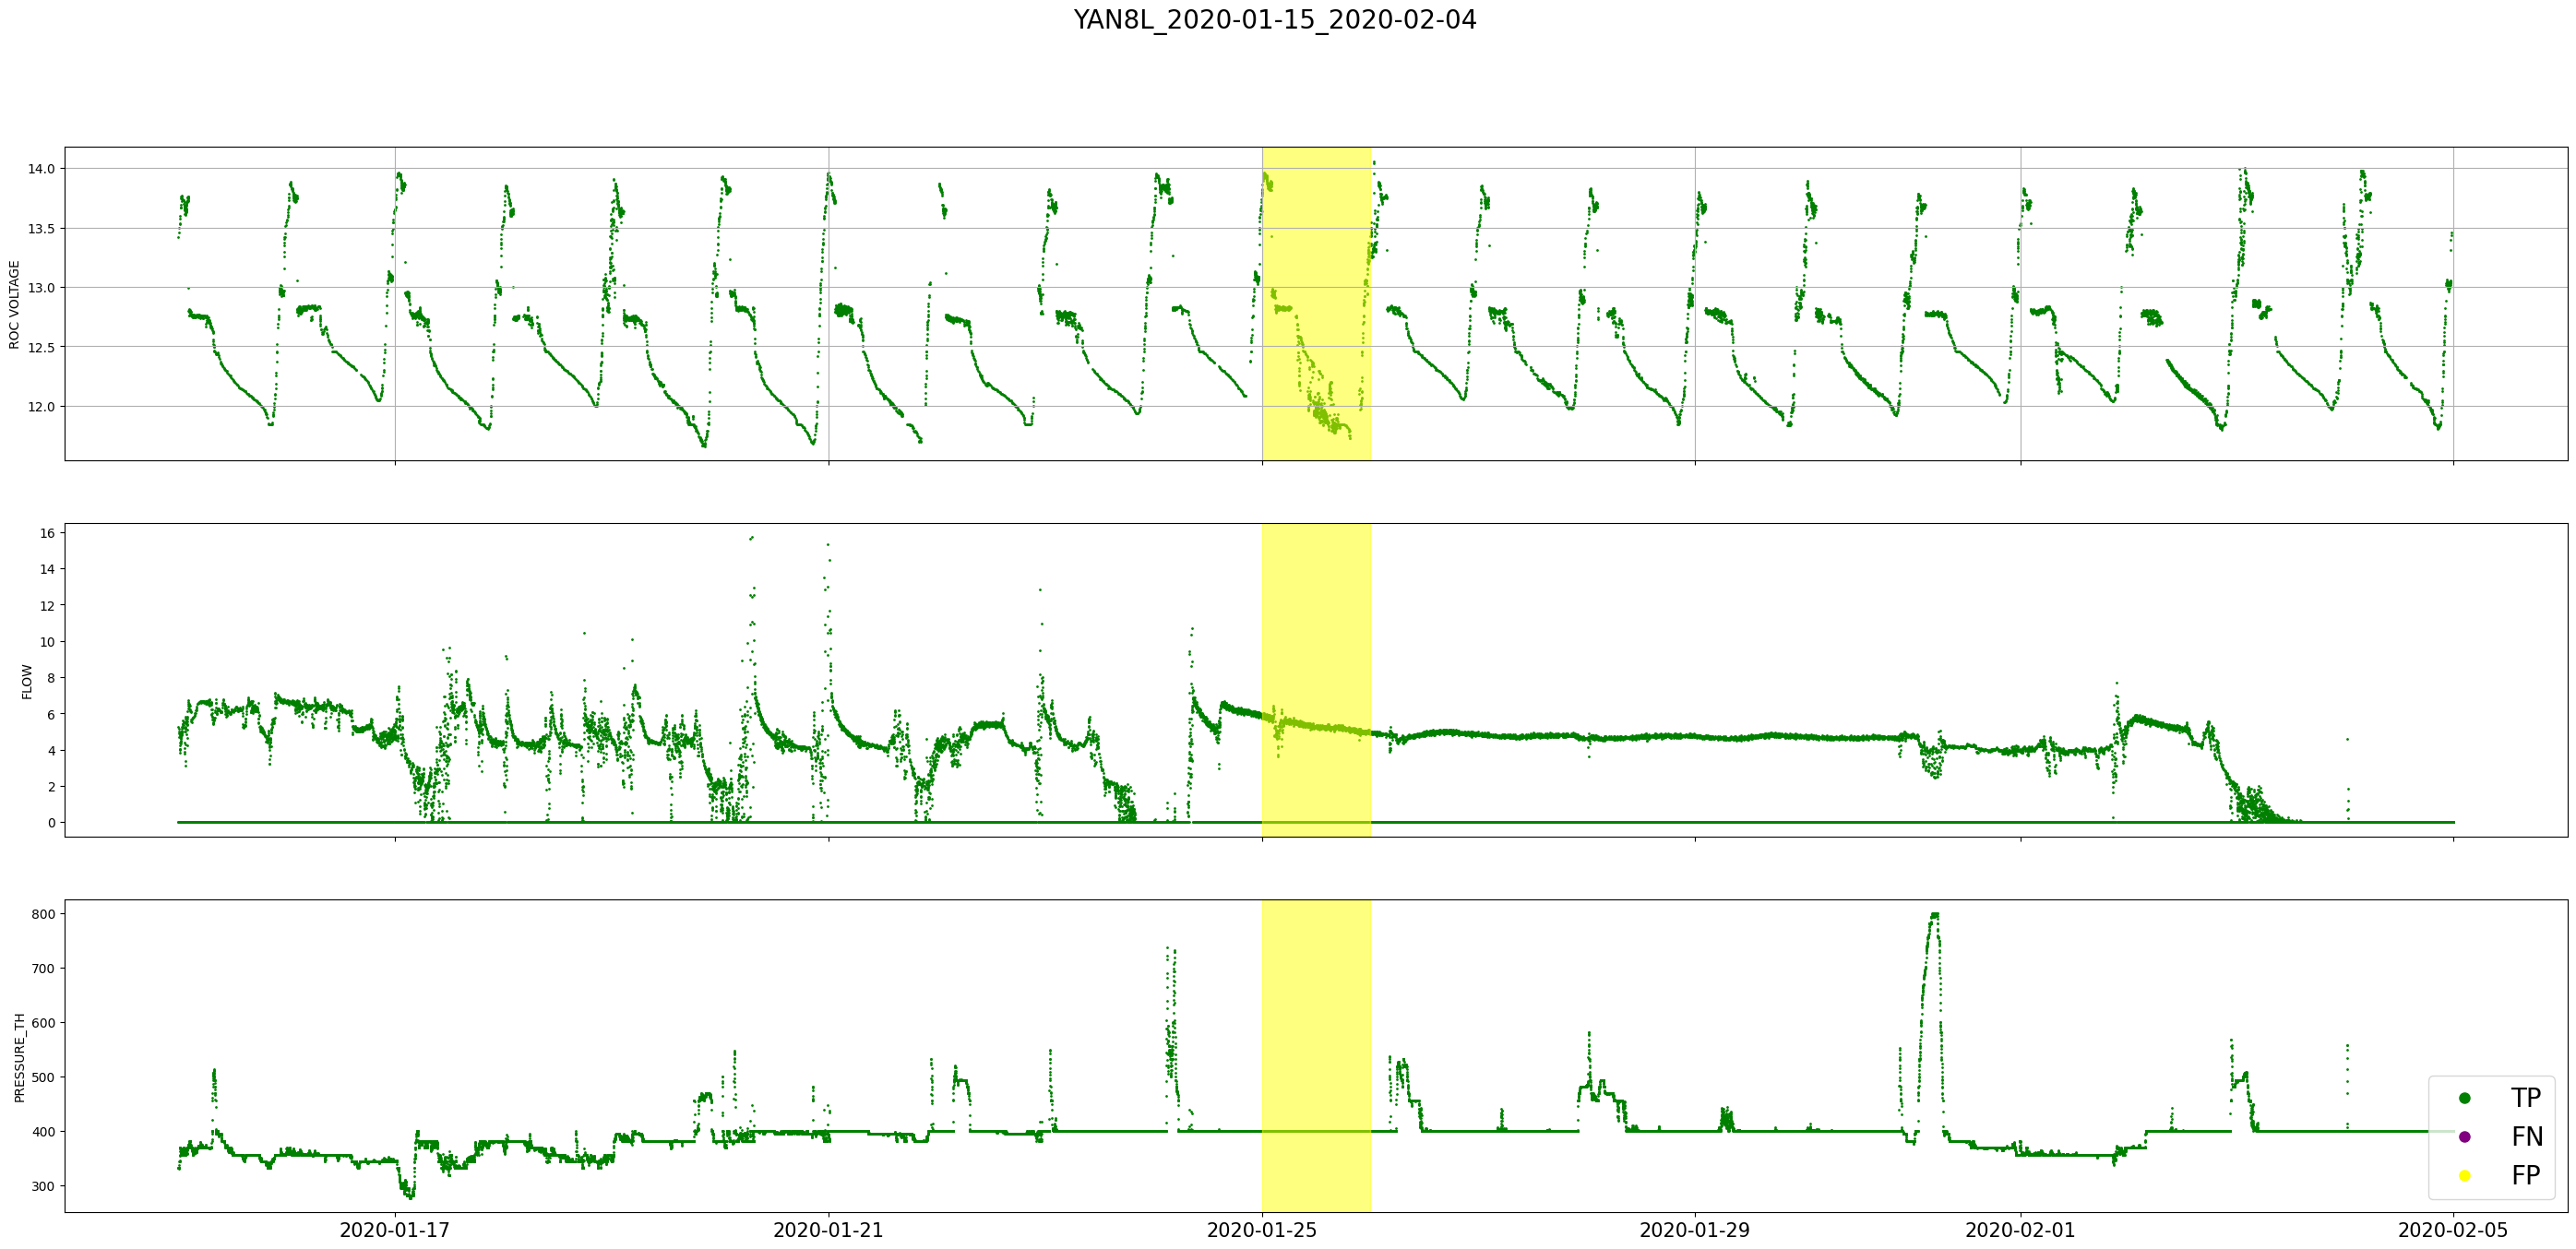

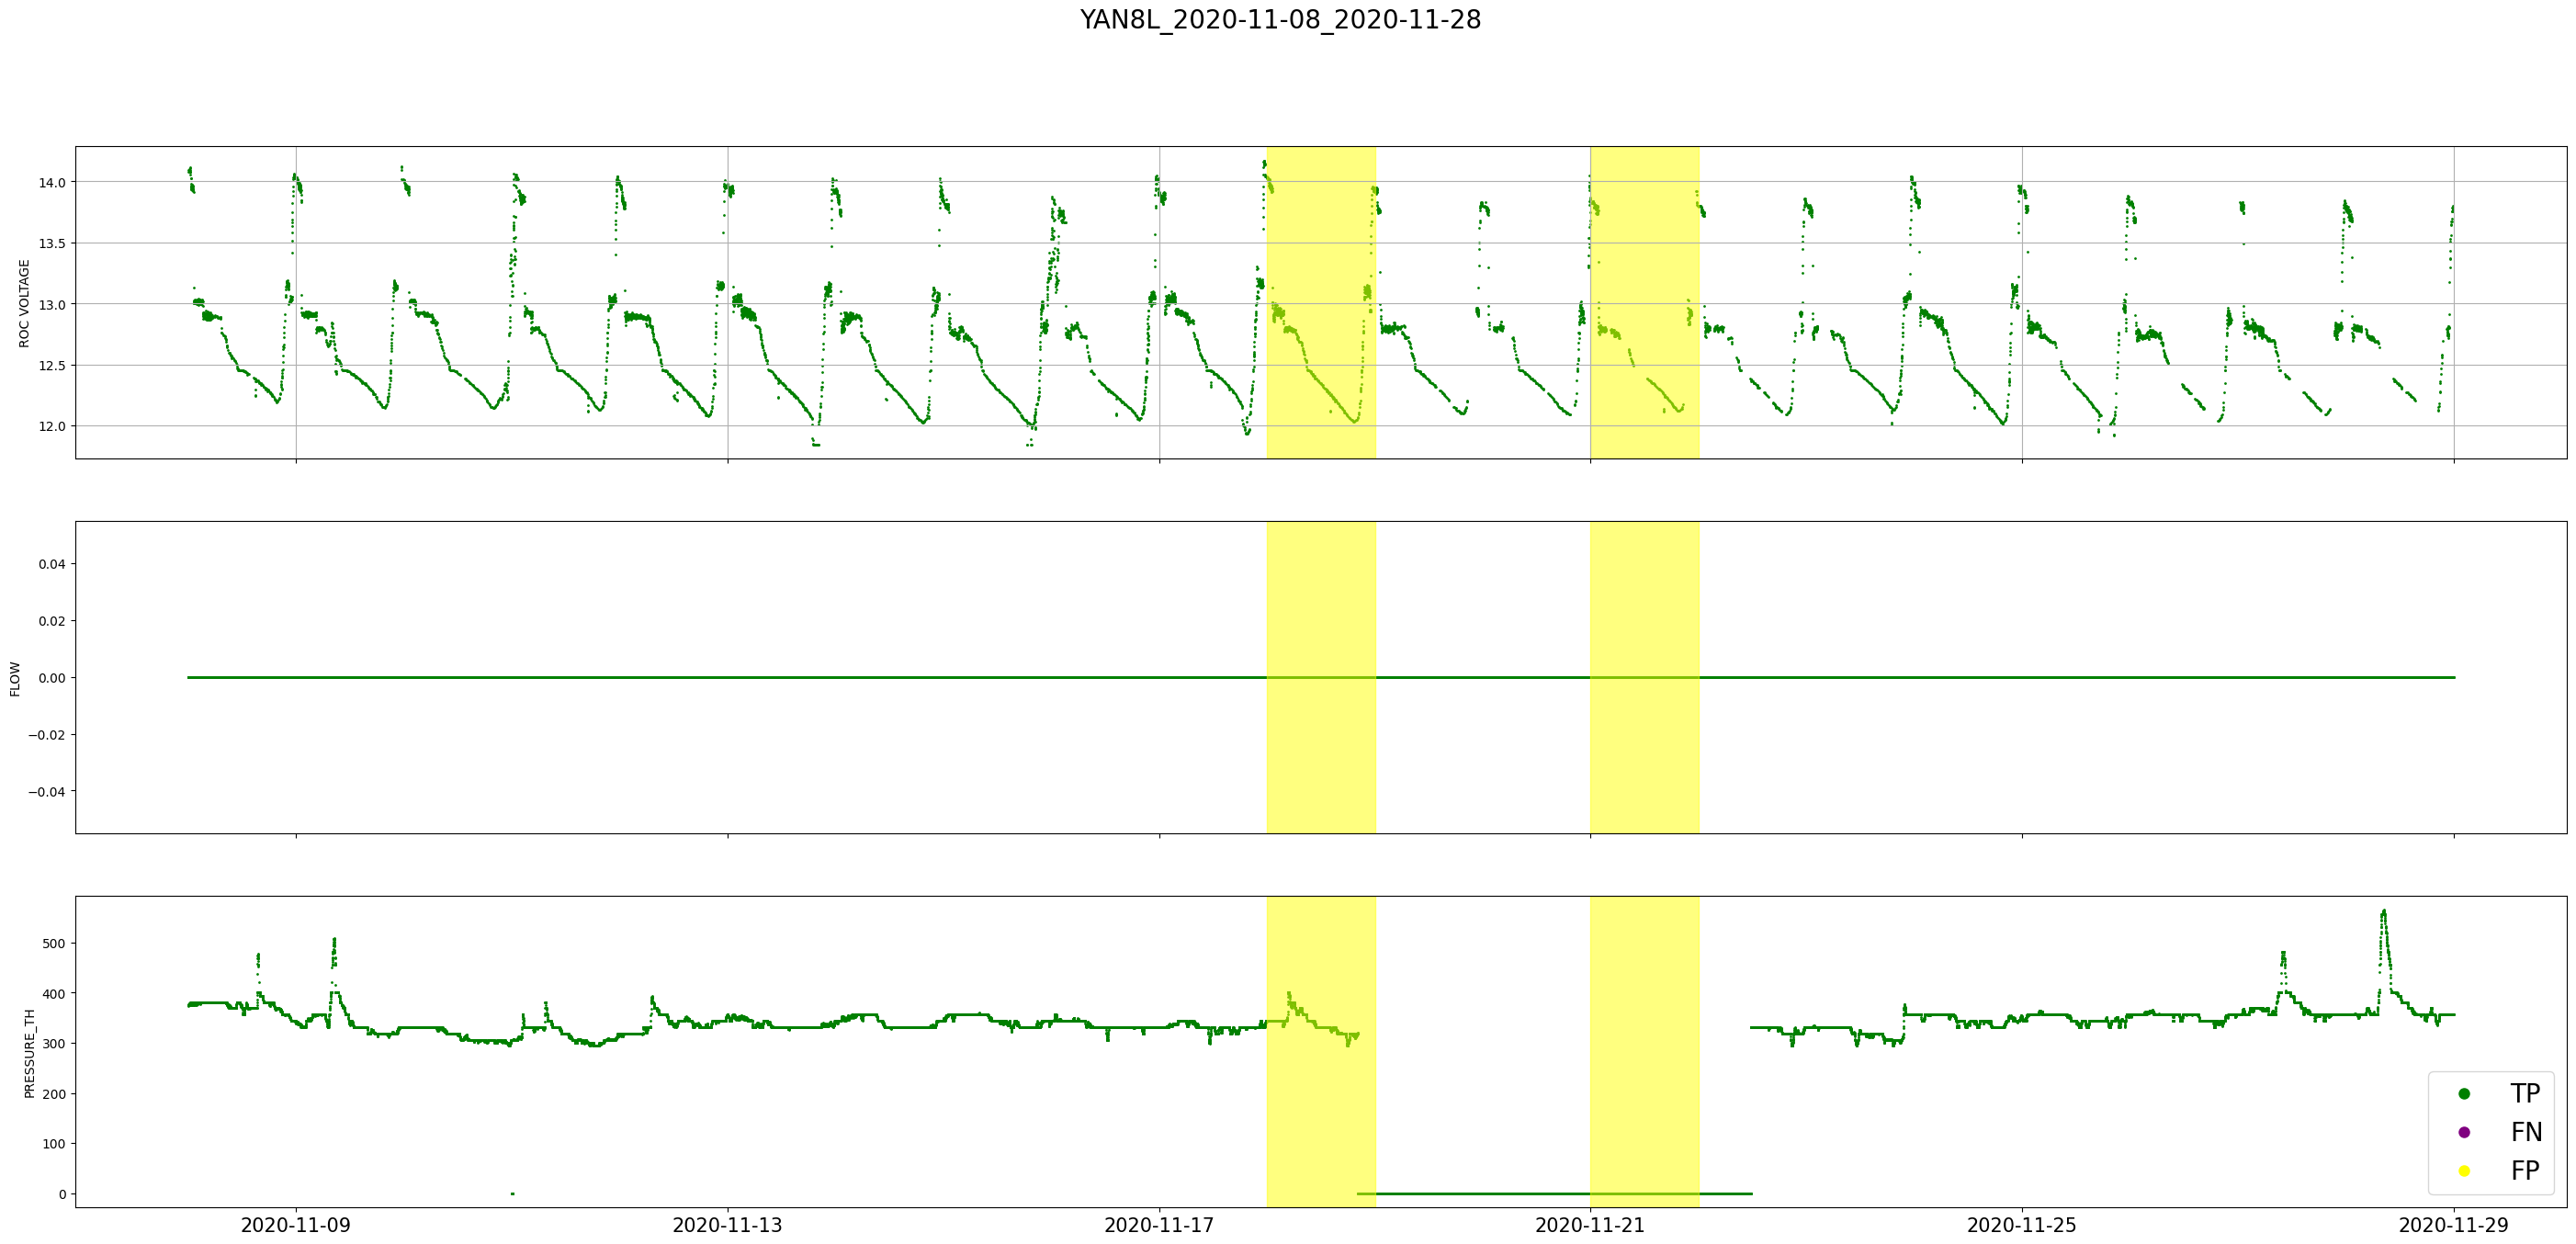

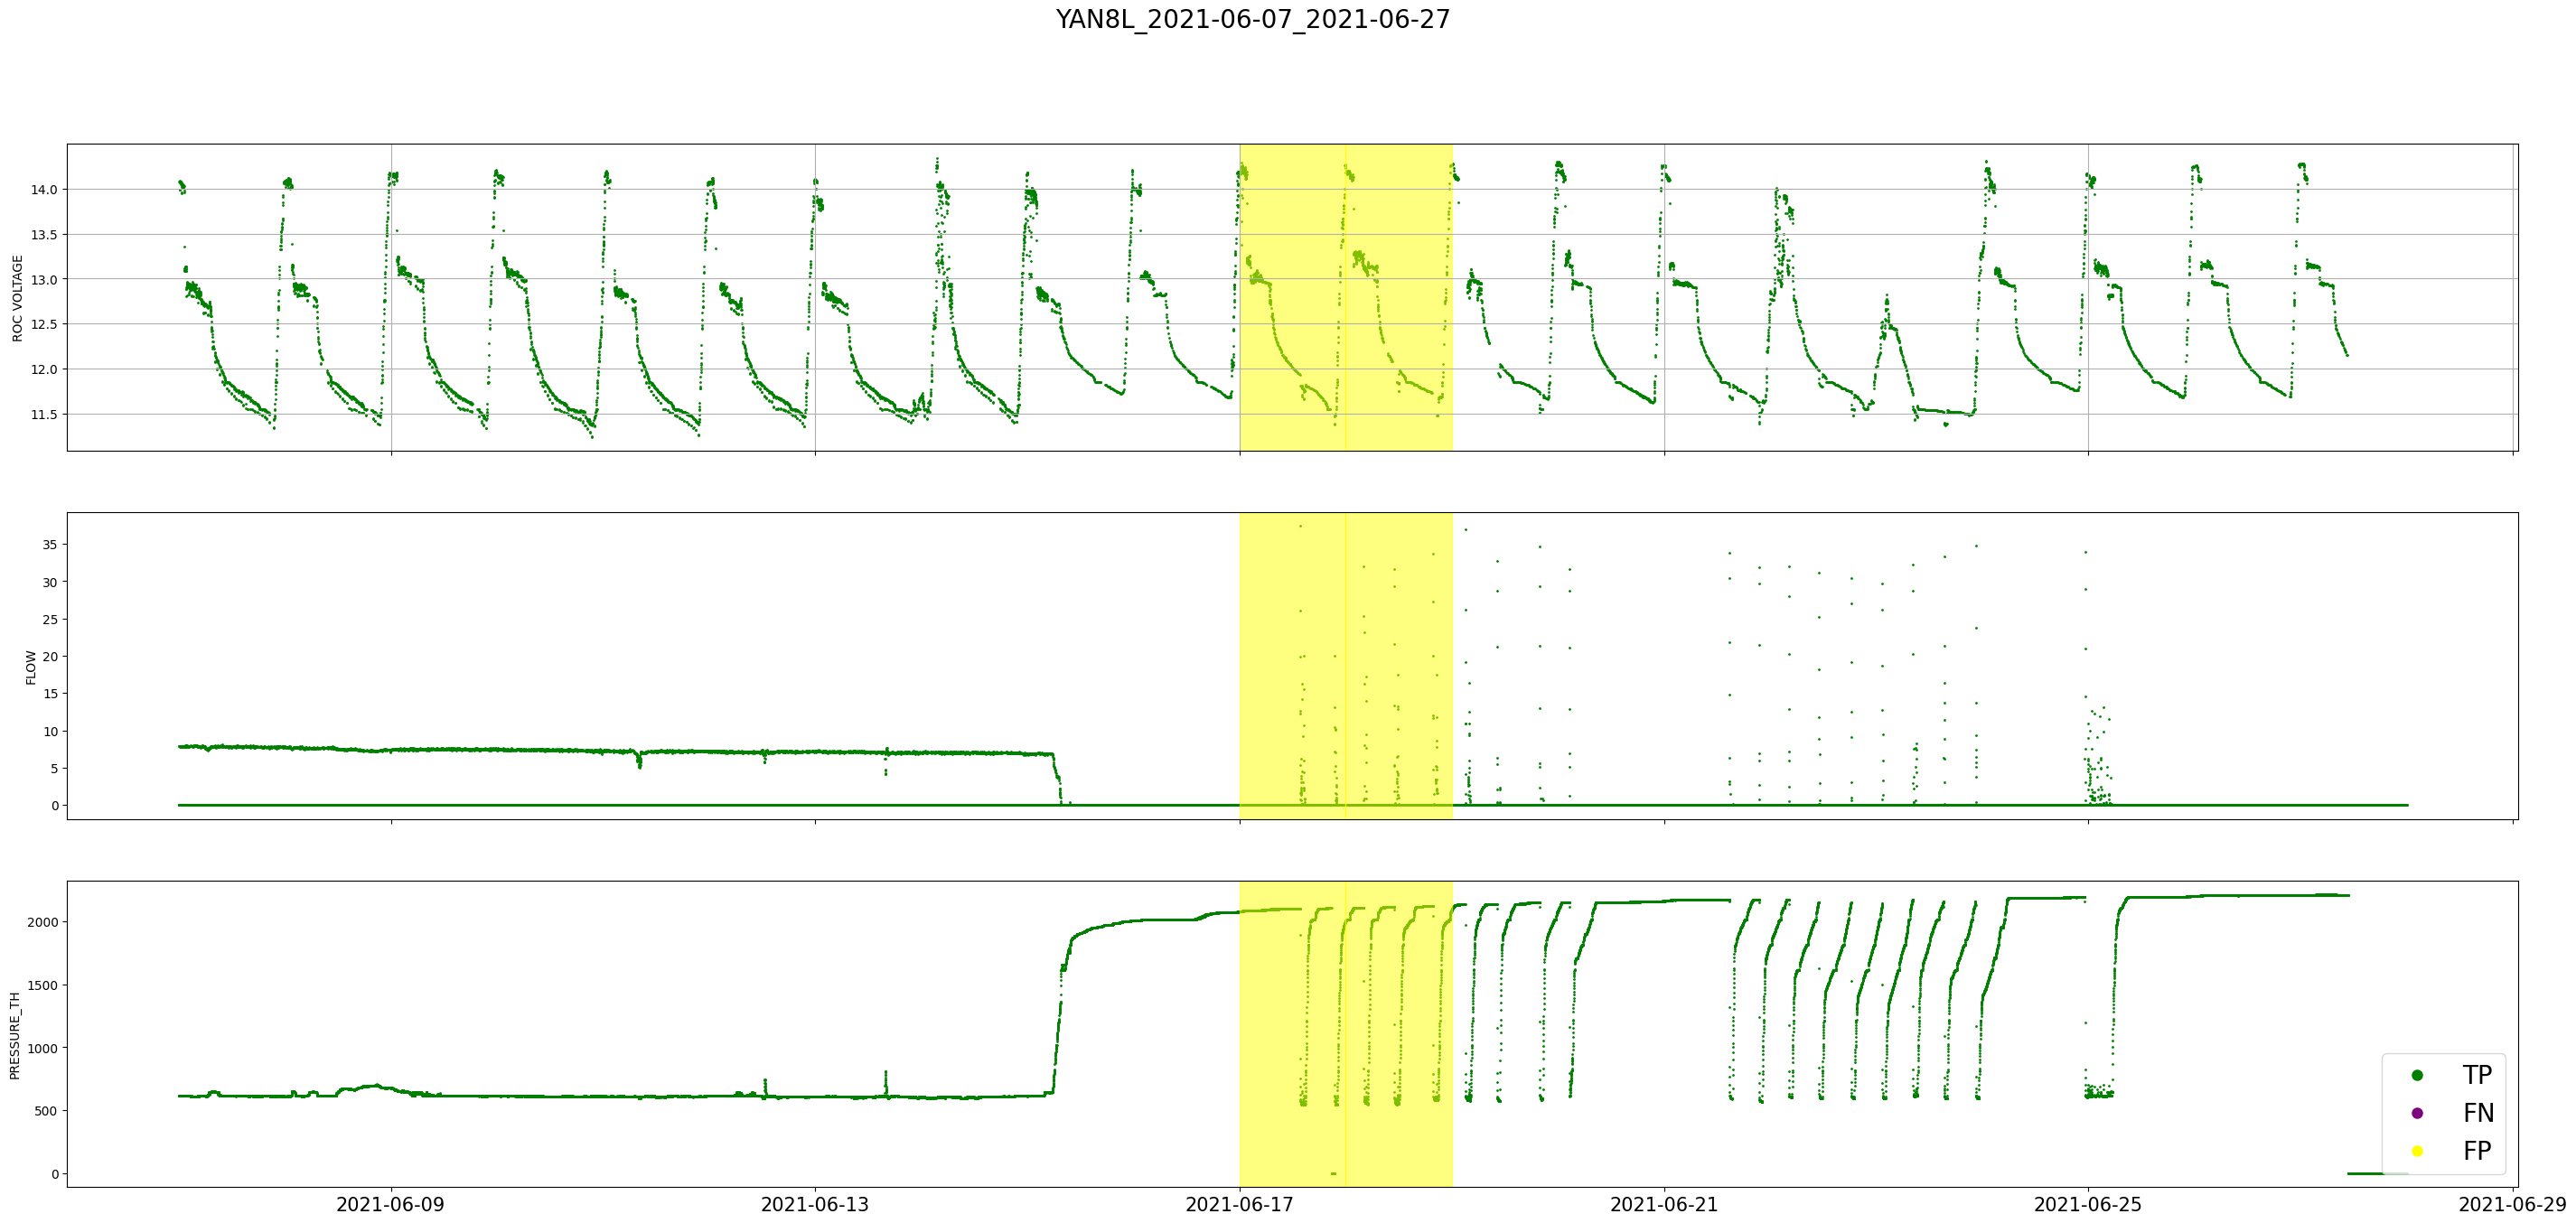

In [4]:
for well in wells:
    model = FeatureExtractor(well)
    print(f"Processing well: {well}")
    model.get_diagnostic_plots("failure_label")

In [ ]:
def plot_failure_min_V_distribution(well_code, model):
    gt = model.data['label_df']
    failure_days = list(set(gt[gt.labels.isin([2,5])].index)&set(model.min_VOLTAGE.index))
    charging_fault_days = gt[gt.labels.isin([6,8])].index
    failure_min_V = model.min_VOLTAGE.loc[failure_days]
    non_failure_days = list(set(model.min_VOLTAGE.index) - set(failure_days) - set(charging_fault_days))
    non_failure_min_V = model.min_VOLTAGE.loc[non_failure_days]
    bins = np.linspace(model.min_VOLTAGE.min(), model.min_VOLTAGE.max(),100)
    plt.hist(failure_min_V, bins=bins, alpha=0.5, label='failure',density=True)
    plt.hist(non_failure_min_V, bins=bins, alpha=0.5, label='non_failure',density=True)
    plt.legend(loc='upper right')
    plt.title(f"Min_VOLTAGE_distribution_{well_code}")
    plt.savefig(PathManager.VIZ_PATH/f"Min_VOLTAGE_distribution_{well_code}.png")
    plt.show()
    
    

In [ ]:
for well in ["WKT3",'YAN1L', 'YAN2L', 'YAN2U', 'YAN4U', 'YAN8L']:#wells:
    model_ = FeatureExtractor(well)
    print(well)
    plot_failure_min_V_distribution(well,model_)